In [ ]:
from google.colab import drive
import os
import json
import random
from typing import Any, Dict, List, Tuple
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def set_seed(
    seed_value: int = 21
) -> None:
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    # if you are using CUDA
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(21)

### 0. Mount to Drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA_DIR = '/content/drive/My Drive/NEU/Graduate/CS_6140/Data/'

### 1. Get Device

In [ ]:
# getting device for training MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cuda".


### 2. Define Helper Functions

##### 2.1) Define Function to Obtain Train-Val-Test Dictionaries

In [ ]:
# random split
def get_train_val_test_arrays(
    X: Dict,
    y: Dict,
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 42
) -> Tuple[
    List[Any],  # X_train
    List[Any],  # X_val
    List[Any],  # X_test
    List[Any],  # y_train
    List[Any],  # y_val
    List[Any],  # y_test
]:
    """
    Purpose: Split the data into training, validation, and test sets.

    :param X: Features matrix.
    :param y: Labels vector.
    test_size (optional): Proportion of the dataset to include in the test split. Default is 0.2.
    val_size (optional): Proportion of the dataset to include in the validation split. Default is 0.2.
    random_state (optional): Random state for reproducibility. Default is 42.
    :return: Tuple containing the training, validation, and testing sets.
    """
    # ensure the keys are sorted so they are aligned in both dictionaries
    keys = sorted(set(X.keys()) & set(y.keys()))
    X_values = [
        X[k] for k in keys
    ]
    y_values = [
        y[k] for k in keys
    ]

    # convert to numpy arrays
    X_values = np.array(X_values)
    y_values = np.array(y_values)

    # split the data into training and the rest
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_values,
        y_values,
        test_size = (test_size + val_size),
        random_state = random_state,
        stratify = y_values
    )

    # split the rest into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size = (val_size / (test_size + val_size)),
        random_state = random_state,
        stratify = y_temp
    )

    return (X_train, X_val, X_test, y_train, y_val, y_test)

##### 2.3) Define Function to Obtain `Dataset`

In [ ]:
def get_tensordataset(
    X,#: torch.Tensor,
    y#: torch.Tensor
) -> TensorDataset:
    dataset = TensorDataset(
        X,
        y
    )
    return dataset

##### 2.4) Define Function to Obtain `DataLoader`

In [ ]:
def get_dataloader(
    dataset: TensorDataset,
    batch_size: int = 64,
    shuffle: bool = True
) -> DataLoader:
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle
    )
    return dataloader

##### 2.5) Define Function to Train, Validate, and Test

In [ ]:
def train_validate_test(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    device: torch.device = torch.device('cpu'),
    epochs: int = 100
) -> Tuple:
    train_val_test_log = dict()
    train_val_test_log['test'] = dict()

    # move model to device
    model = model.to(device)

    # instantiate train loss
    best_total_train_loss = float('inf')

    # define the best epoch to be the epoch with the best validation AUC
    best_val_auc = float('-inf')
    best_val_auc_idx = None
    best_model_state = None
    best_optim_state = None

    # define lists to keep track of best validation epoch (best AUC) and associated test true/preds
    best_val_y_true_list = []
    best_val_y_hat_list = []
    associated_test_y_true_list = []
    associated_test_y_hat_list = []

    # loop through epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_idx = epoch + 1

        train_val_test_log[epoch_idx] = {
            'train': dict(),
            'val': dict(),
            'secondval': dict(),
        }

        # 1. BEGIN TRAINING

        # set model to train mode
        model.train()

        # define best train loss, val AUC for this epoch
        total_train_loss = 0
        total_val_loss = 0
        total_test_loss = 0
        val_auc = 0


        total_secondval_loss = 0

        # loop through data batches
        for X_train_batch, y_train_batch in train_loader:

            # [batch_size, sequence_length, features] -> [sequence_length, batch_size, features]
            X_train_batch = X_train_batch.transpose(0, 1)

            # move tensors to device
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

            # reset gradients to 0 before starting backpropagation
            optimizer.zero_grad()

            # compute model predictions for the batch
            y_train_hat = model(
                X_train_batch
            )

            # compute the loss for train batch
            train_batch_loss = loss_fn(
                y_train_hat,
                y_train_batch
            )

            # backpropagate the batch loss and compute gradients
            train_batch_loss.backward()

            # perform single optimization step by updating model parameters based on gradients
            optimizer.step()

            # accumulate epoch's total train loss
            total_train_loss += train_batch_loss.item()

        train_val_test_log[epoch_idx]['train']['loss'] = total_train_loss

        # update best train loss if necessary
        if total_train_loss < best_total_train_loss:
            best_total_train_loss = total_train_loss

        # ------------------------------------------------------------------------------------------
        # 2. BEGIN VALIDATION

        # switch model to evaluation mode
        model.eval()

        # keep track of evaluation metrics
        val_y_true_list = []
        val_y_hat_list = []

        # keep track of secondval metrics
        secondval_y_true_list = []
        secondval_y_hat_list = []

        # disable computing gradients (we are just evaluating)
        with torch.no_grad():

            # loop through validation batches
            for X_val_batch, y_val_batch in val_loader:

                # [batch_size, sequence_length, features] -> [sequence_length, batch_size, features]
                X_val_batch = X_val_batch.transpose(0, 1)

                # move tensors to device
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

                # get predictions from trained model
                y_val_hat = model(
                    X_val_batch
                )

                # append y and y_hat to lists
                val_y_true_list.append(y_val_batch.cpu())
                val_y_hat_list.append(y_val_hat.cpu())

                # compute the loss for val batch
                val_batch_loss = loss_fn(
                    y_val_hat,
                    y_val_batch
                )

                # total_val_loss
                total_val_loss += val_batch_loss.item()

            # flatten lists of batch outputs into single array
            val_y_true_list = torch.cat(val_y_true_list).numpy()
            val_y_hat_list = torch.cat(val_y_hat_list).numpy()

            # compute validation AUC
            val_auc = roc_auc_score(
                y_true = val_y_true_list,
                y_score = val_y_hat_list
            )

            # check if we have found a new best validation AUC
            if best_val_auc < val_auc:
                best_val_auc = val_auc
                best_val_auc_idx = epoch_idx

                # keep track of best val true and preds
                best_val_y_true_list = val_y_true_list
                best_val_y_hat_list = val_y_hat_list

                # keep track of model and optimizer
                best_model_state = model.state_dict()
                best_optim_state = optimizer.state_dict()

            train_val_test_log[epoch_idx]['val']['auc'] = val_auc
            train_val_test_log[epoch_idx]['val']['loss'] = total_val_loss

            # -------------------------------------------------------------------------------------
            # ~ BEGIN TEST ("secondval")

            # loop through secondval batches
            for X_secondval_batch, y_secondval_batch in test_loader:

                # [batch_size, sequence_length, features] -> [sequence_length, batch_size, features]
                X_secondval_batch = X_secondval_batch.transpose(0, 1)

                # move tensors to device
                X_secondval_batch = X_secondval_batch.to(device)
                y_secondval_batch = y_secondval_batch.to(device)

                # get predictions from trained model
                y_secondval_hat = model(
                    X_secondval_batch
                )

                # append y and y_hat to lists
                secondval_y_true_list.append(y_secondval_batch.cpu())
                secondval_y_hat_list.append(y_secondval_hat.cpu())

                # compute the loss for val batch
                secondval_batch_loss = loss_fn(
                    y_secondval_hat,
                    y_secondval_batch
                )

                # total_val_loss
                total_secondval_loss += secondval_batch_loss.item()

            # flatten lists of batch outputs into single array
            secondval_y_true_list = torch.cat(secondval_y_true_list).numpy()
            secondval_y_hat_list = torch.cat(secondval_y_hat_list).numpy()

            secondval_auc = roc_auc_score(
                y_true = secondval_y_true_list,
                y_score = secondval_y_hat_list
            )
            train_val_test_log[epoch_idx]['secondval']['auc'] = secondval_auc
            train_val_test_log[epoch_idx]['secondval']['loss'] = total_secondval_loss

    # ------------------------------------------------------------------------------------------
    # 3. BEGIN TESTING

    # switch model to evaluation mode
    model.eval()

    # disable computing gradients (we are just evaluating)
    with torch.no_grad():

        # load in model and optimizer from best val AUC epoch
        model.load_state_dict(
            best_model_state
        )
        optimizer.load_state_dict(
            best_optim_state
        )

        # loop through test batches
        for X_test_batch, y_test_batch in test_loader:

            # [batch_size, sequence_length, features] -> [sequence_length, batch_size, features]
            X_test_batch = X_test_batch.transpose(0, 1)

            # move tensors to device
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            # get predictions from trained model
            y_test_hat = model(
                X_test_batch
            )

            # convert tensors to 2D list and move to cpu
            associated_test_y_true_list.append(y_test_batch.cpu())
            associated_test_y_hat_list.append(y_test_hat.cpu())

            # compute the loss for val batch
            test_batch_loss = loss_fn(
                y_test_hat,
                y_test_batch
            )

            # total_val_loss
            total_test_loss += test_batch_loss.item()

        # flatten lists of batch outputs into single array
        associated_test_y_true_list = torch.cat(associated_test_y_true_list).numpy()
        associated_test_y_hat_list = torch.cat(associated_test_y_hat_list).numpy()

        train_val_test_log['test']['auc'] = roc_auc_score(
            y_true = associated_test_y_true_list,
            y_score = associated_test_y_hat_list
        )
        train_val_test_log['test']['loss'] = total_test_loss

    return (
        best_val_auc_idx,
        best_val_y_true_list, best_val_y_hat_list,
        associated_test_y_true_list, associated_test_y_hat_list,
        train_val_test_log
    )

##### 2.6) Define Function to Evaluate at Target TPR and FPR Values

In [ ]:
def display_val_test_confusion_matrices(
    best_val_data_confusion_matrix,
    associated_test_data_confusion_matrix,
    val_auc: float,
    test_auc: float,
    target_metric_substring: str
) -> None:
    # plotting both confusion matrices side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # val confusion matrix plot
    sns.heatmap(
        best_val_data_confusion_matrix,
        annot = True,
        fmt = "d",
        linewidths = 0.5,
        square = True,
        cmap = 'Blues',
        xticklabels = ['Negative', 'Positive'],
        yticklabels = ['Negative', 'Positive'],
        ax = axes[0]
    )
    axes[0].set_ylabel('Actual Label')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_title(
        f'Val Data Confusion Matrix, {target_metric_substring} (AUC: {val_auc:.2f})',
        size = 10
    )

    # test confusion matrix plot
    sns.heatmap(
        associated_test_data_confusion_matrix,
        annot = True,
        fmt = "d",
        linewidths = 0.5,
        square = True,
        cmap = 'Blues',
        xticklabels = ['Negative', 'Positive'],
        yticklabels = ['Negative', 'Positive'],
        ax = axes[1]
    )
    axes[1].set_ylabel('Actual Label')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_title(
        f'Test Data Confusion Matrix, {target_metric_substring} (AUC: {test_auc:.2f})',
        size = 10
    )

    plt.tight_layout()
    plt.show()

In [ ]:
def find_threshold(
    metric_values: np.ndarray,
    targets: List[float],
    thresholds_val: np.ndarray
) -> List[float]:
    """
    Purpose: Finds thresholds corresponding to the closest values in `metric_values` for each
        target in `targets`.
    :param metric_values (np.ndarray): Array of metric values (either TPR or FPR from ROC).
    :param targets (List[float]): List of target values for which to find the closest thresholds.
    :param thresholds_val (np.ndarray): Array of thresholds corresponding to the metric values.
    :return: List[float] containing thresholds closest to each target metric value.
    """
    closest_thresholds = [
        thresholds_val[np.argmin(np.abs(metric_values - target))] for target in targets
    ]
    return closest_thresholds

In [ ]:
def evaluate_thresholds(
    y_true_val,
    y_pred_val,
    y_true_test,
    y_pred_test,
    target_tprs: List[float] = [0.8],
    target_fprs: List[float] = [0.05]
) -> None:
    # get ROC AUC for both val and test
    val_auc = roc_auc_score(
        y_true = y_true_val,
        y_score = y_pred_val
    )
    test_auc = roc_auc_score(
        y_true = y_true_test,
        y_score = y_pred_test
    )

    # compute ROC curve for validation set;
    # we will use val threshold on test, too
    fpr_val, tpr_val, thresholds_val = roc_curve(
        y_true_val,
        y_pred_val
    )

    # process each target TPR
    if target_tprs:
        thresholds_tpr = find_threshold(
            metric_values = tpr_val,
            targets = target_tprs,
            thresholds_val = thresholds_val
        )

        for i, threshold in enumerate(thresholds_tpr):
            # apply threshold to both validation and test data
            pred_val = [
                1 if x >= threshold else 0 for x in y_pred_val
            ]
            pred_test = [
                1 if x >= threshold else 0 for x in y_pred_test
            ]

            # calculate metrics for validation set
            val_recall = recall_score(y_true_val, pred_val)
            val_accuracy = accuracy_score(y_true_val, pred_val)
            val_conf_matrix = confusion_matrix(y_true_val, pred_val)

            # calculate metrics for test set
            test_recall = recall_score(y_true_test, pred_test)
            test_accuracy = accuracy_score(y_true_test, pred_test)
            test_conf_matrix = confusion_matrix(y_true_test, pred_test)

            # print results
            print(f"\t- TPR Target: {target_tprs[i]}")
            print(f"\t\t- Validation Accuracy: {val_accuracy}")
            print(f"\t\t- Validation Recall: {val_recall}")
            print(f"\t\t- Test Accuracy: {test_accuracy}")
            print(f"\t\t- Test Recall: {test_recall}")

            # print confusion matrices
            display_val_test_confusion_matrices(
                best_val_data_confusion_matrix = val_conf_matrix,
                associated_test_data_confusion_matrix = test_conf_matrix,
                val_auc = val_auc,
                test_auc = test_auc,
                target_metric_substring = f"TPR={target_tprs[i]}"
            )

    # process each target FPR
    if target_fprs:
        thresholds_fpr = find_threshold(
            fpr_val,
            target_fprs,
            thresholds_val
        )

        for i, threshold in enumerate(thresholds_fpr):

            # apply threshold to both validation and test data
            pred_val = [
                1 if x >= threshold else 0 for x in y_pred_val
            ]
            pred_test = [
                1 if x >= threshold else 0 for x in y_pred_test
            ]

            # calculate metrics for validation and test sets
            val_accuracy = accuracy_score(y_true_val, pred_val)
            val_conf_matrix = confusion_matrix(y_true_val, pred_val)
            val_specificity = val_conf_matrix[0, 0] / (val_conf_matrix[0, 0] + val_conf_matrix[0, 1])

            test_accuracy = accuracy_score(y_true_test, pred_test)
            test_conf_matrix = confusion_matrix(y_true_test, pred_test)
            test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

            # print results for validation and test sets
            print(f"\t- FPR Target: {target_fprs[i]}")
            print(f"\t\t- Validation Accuracy: {val_accuracy}")
            print(f"\t\t- Validation Specificity: {val_specificity}")
            print(f"\t\t- Test Accuracy: {test_accuracy}")
            print(f"\t\t- Test Specificity: {test_specificity}")

            # print confusion matrices
            display_val_test_confusion_matrices(
                best_val_data_confusion_matrix = val_conf_matrix,
                associated_test_data_confusion_matrix = test_conf_matrix,
                val_auc = val_auc,
                test_auc = test_auc,
                target_metric_substring = f"FPR={target_fprs[i]}"
            )


### 3. Define Models

##### 3.1) MLP

In [ ]:
def make_mlp(
    input_dim: int,
    hidden_dims: List[int],
    output_dim: int,
    hidden_activation: nn.Module = nn.ReLU,
    dropout: float = 0.0
) -> nn.Sequential:
    num_hidden_layers = len(hidden_dims)
    seq_list = []
    if num_hidden_layers > 0:
        seq_list.append(nn.Linear(input_dim, hidden_dims[0]))
        seq_list.append(hidden_activation())

        if dropout > 0.0:
            seq_list.append(nn.Dropout(dropout))

        for i in range(1, num_hidden_layers):
            seq_list.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            seq_list.append(hidden_activation())

            if dropout > 0.0:
                seq_list.append(nn.Dropout(dropout))

        seq_list.append(nn.Linear(hidden_dims[-1], output_dim))
    else:
        seq_list.append(nn.Linear(input_dim, output_dim))

    return nn.Sequential(*seq_list)

##### 3.2) RNN

In [ ]:
class RNN_Model(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        classifier_mlp: nn.Module
    ) -> None:
        super(RNN_Model, self).__init__()

        # set RNN attributes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # instantiate RNN
        self.rnn = nn.RNN(
            **{
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'dropout': self.dropout,
            }
        )

        # set classifier MLP attribute
        if classifier_mlp is None:
            raise ValueError("Classifier MLP cannot be None!")
        self.classifier_mlp = classifier_mlp

    def forward(
        self,
        x: torch.Tensor
    ) -> torch.Tensor:
        """
        """
        # initialize hidden state for first input with zeros
        h0 = torch.zeros(
            size = (self.num_layers, x.size(1), self.hidden_size),
            device = x.device
        ).requires_grad_()

        # forward propagation
        _, h_last_time_step_all_hidden_layers = self.rnn(
            input = x,
            hx = h0.detach()
        )

        # obtain last layer of last hidden state
        h_final_hidden_state = h_last_time_step_all_hidden_layers[-1, :, :]

        # obtain last logits
        last_logits = self.classifier_mlp(
            h_final_hidden_state
        )

        return last_logits

##### 3.3) LSTM

In [ ]:
class LSTM_Model(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        classifier_mlp: nn.Module
    ) -> None:
        super(LSTM_Model, self).__init__()

        # set LSTM attributes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # instantiate LSTM
        self.rnn = nn.LSTM(
            **{
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'dropout': self.dropout,
            }
        )

        # set classifier MLP attribute
        if classifier_mlp is None:
            raise ValueError("Classifier MLP cannot be None!")
        self.classifier_mlp = classifier_mlp

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        """
        """
        # initialize hidden state and cell for first input with zeros
        h0 = torch.zeros(
            size = (self.num_layers, x.size(1), self.hidden_size),
            device = x.device
        )
        c0 = torch.zeros(
            size = (self.num_layers, x.size(1), self.hidden_size),
            device = x.device
        )

        # forward propagation;  hn is the last hidden state, cn is the last cell state
        _, (h_last_time_step_all_hidden_layers, cn) = self.rnn(
            x,
            (h0, c0)
        )

        # obtain last layer of last hidden state
        h_final_hidden_state  = h_last_time_step_all_hidden_layers[-1, :, :]

        # obtain last logits
        last_logits = self.classifier_mlp(
            h_final_hidden_state
        )

        return last_logits

##### 3.4) GRU

In [ ]:
class GRU_Model(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        classifier_mlp: nn.Module
    ) -> None:
        super(GRU_Model, self).__init__()

        # set LSTM attributes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # instantiate LSTM
        self.rnn = nn.GRU(
            **{
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'dropout': self.dropout,
            }
        )

        # set classifier MLP attribute
        if classifier_mlp is None:
            raise ValueError("Classifier MLP cannot be None!")
        self.classifier_mlp = classifier_mlp

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        """
        """
        # initialize hidden state for first input with zeros
        h0 = torch.zeros(
            size = (self.num_layers, x.size(1), self.hidden_size),
            device = x.device
        )

        # forward propagation
        _, h_last_time_step_all_hidden_layers = self.rnn(
            input = x,
            hx = h0.detach()
        )

        # obtain last layer of last hidden state
        h_final_hidden_state  = h_last_time_step_all_hidden_layers[-1, :, :]

        # obtain last logits
        last_logits = self.classifier_mlp(
            h_final_hidden_state
        )

        return last_logits

### 4. Experiments

In [ ]:
NUM_EPOCHS = 100
WEIGHT_DECAY = 1.00E-06
NUM_RNN_FEATURES = 25

##### Experiment #3

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [07:54<00:00,  4.75s/it]


	- Best Val AUC Epoch: 76
	- Best Val AUC: 0.844982492997199
	- Associated Test AUC: 0.8365011004401761


	- TPR Target: 0.8
		- Validation Accuracy: 0.7493131868131868
		- Validation Recall: 0.8
		- Test Accuracy: 0.9262362637362638
		- Test Recall: 0.5857142857142857


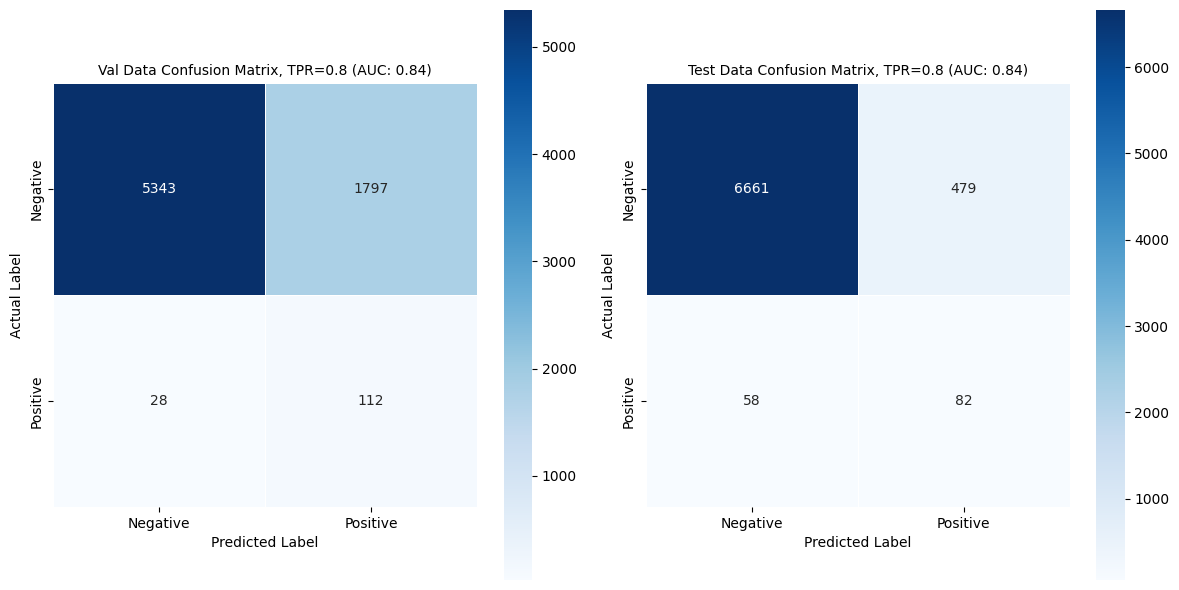

	- FPR Target: 0.05
		- Validation Accuracy: 0.942032967032967
		- Validation Specificity: 0.949719887955182
		- Test Accuracy: 0.9807692307692307
		- Test Specificity: 1.0


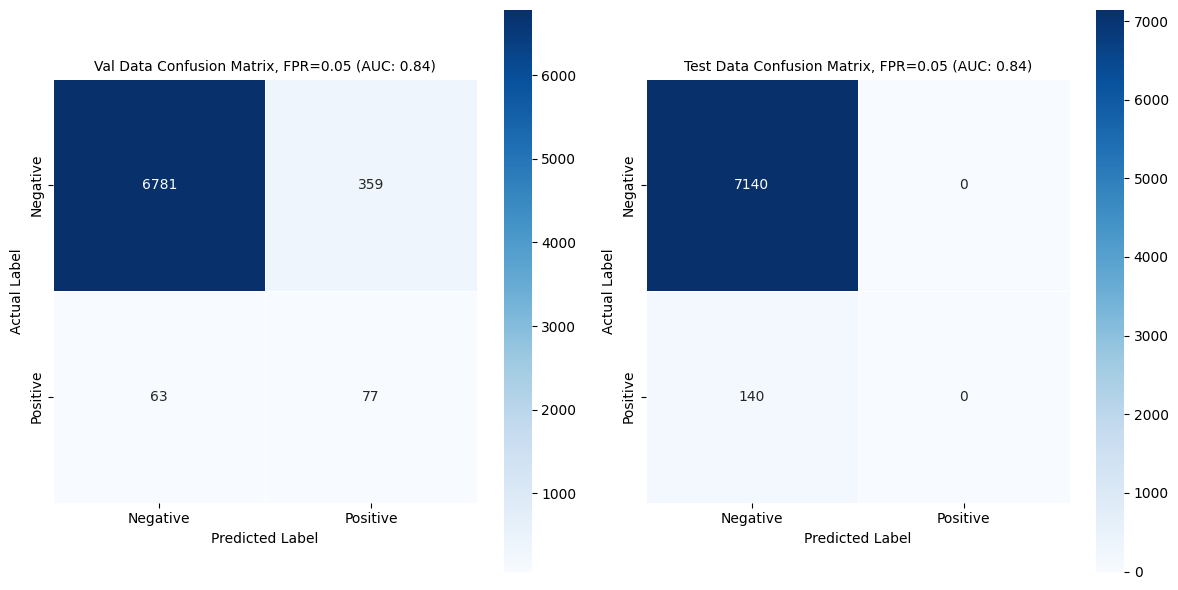

In [ ]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.8365011004401761, 'loss': 8.71625944506377}
1 -> {'train': {'loss': 48.18368924036622}, 'val': {'auc': 0.7069332733093238, 'loss': 10.829803850501776}, 'secondval': {'auc': 0.7115361144457784, 'loss': 10.828474773094058}}
2 -> {'train': {'loss': 32.59220634307712}, 'val': {'auc': 0.6259353741496598, 'loss': 10.858340511098504}, 'secondval': {'auc': 0.5893092236894757, 'loss': 10.859755730256438}}
3 -> {'train': {'loss': 31.399630142375827}, 'val': {'auc': 0.7487505002000799, 'loss': 11.159757513552904}, 'secondval': {'auc': 0.7693357342937175, 'loss': 11.205722098238766}}
4 -> {'train': {'loss': 30.620518134906888}, 'val': {'auc': 0.8056397559023609, 'loss': 9.950550176668912}, 'secondval': {'auc': 0.8093427370948378, 'loss': 10.121354420669377}}
5 -> {'train': {'loss': 28.08745953720063}, 'val': {'auc': 0.8031127450980391, 'loss': 8.505842654034495}, 'secondval': {'auc': 0.8171058423369347, 'loss': 8.80806191638112}}
6 -> {'train': {'loss': 27.891746969427913}, 'val'

##### Experiment #4

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [08:17<00:00,  4.98s/it]


	- Best Val AUC Epoch: 38
	- Best Val AUC: 0.929406262505002
	- Best Test AUC: 0.8854261704681873


	- TPR Target: 0.8
		- Validation Accuracy: 0.893956043956044
		- Validation Recall: 0.8
		- Test Accuracy: 0.9123626373626373
		- Test Recall: 0.6142857142857143


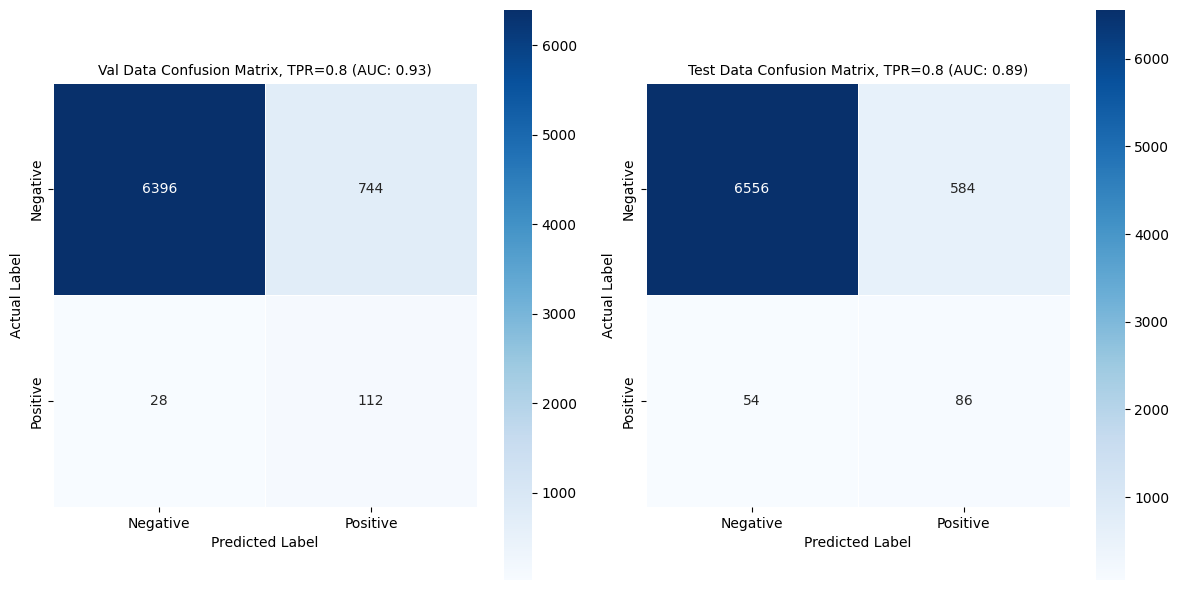

	- FPR Target: 0.05
		- Validation Accuracy: 0.9416208791208791
		- Validation Specificity: 0.9481792717086834
		- Test Accuracy: 0.9293956043956044
		- Test Specificity: 0.9368347338935574


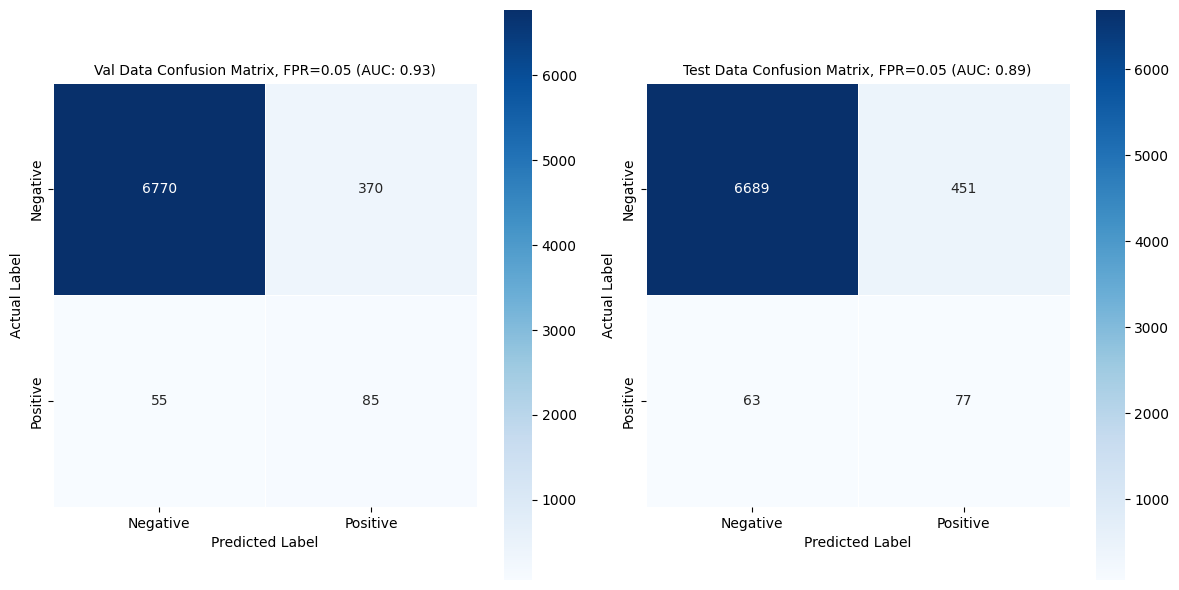

In [ ]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.8854261704681873, 'loss': 8.389222432859242}
1 -> {'train': {'loss': 49.29869211092591}, 'val': {'auc': 0.7502511004401761, 'loss': 10.848232476040721}, 'secondval': {'auc': 0.7292682072829132, 'loss': 10.850483417510986}}
2 -> {'train': {'loss': 32.40706052351743}, 'val': {'auc': 0.7633043217286914, 'loss': 10.468513069674373}, 'secondval': {'auc': 0.7491801720688276, 'loss': 10.520111871883273}}
3 -> {'train': {'loss': 31.516425848938525}, 'val': {'auc': 0.8161584633853542, 'loss': 9.251687735319138}, 'secondval': {'auc': 0.8078141256502601, 'loss': 9.56132010743022}}
4 -> {'train': {'loss': 29.353364014066756}, 'val': {'auc': 0.8623609443777511, 'loss': 8.520390952937305}, 'secondval': {'auc': 0.854265706282513, 'loss': 8.997501489706337}}
5 -> {'train': {'loss': 28.219898020848632}, 'val': {'auc': 0.8875790316126451, 'loss': 8.784655340015888}, 'secondval': {'auc': 0.8721898759503802, 'loss': 9.189641512930393}}
6 -> {'train': {'loss': 29.05500706192106}, 'val': {

##### Experiment #11

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [07:37<00:00,  4.57s/it]


	- Best Val AUC Epoch: 99
	- Best Val AUC: 0.9761194477791117
	- Best Test AUC: 0.9651640656262506


	- TPR Target: 0.8
		- Validation Accuracy: 0.9598901098901099
		- Validation Recall: 0.8
		- Test Accuracy: 0.9581043956043956
		- Test Recall: 0.7214285714285714


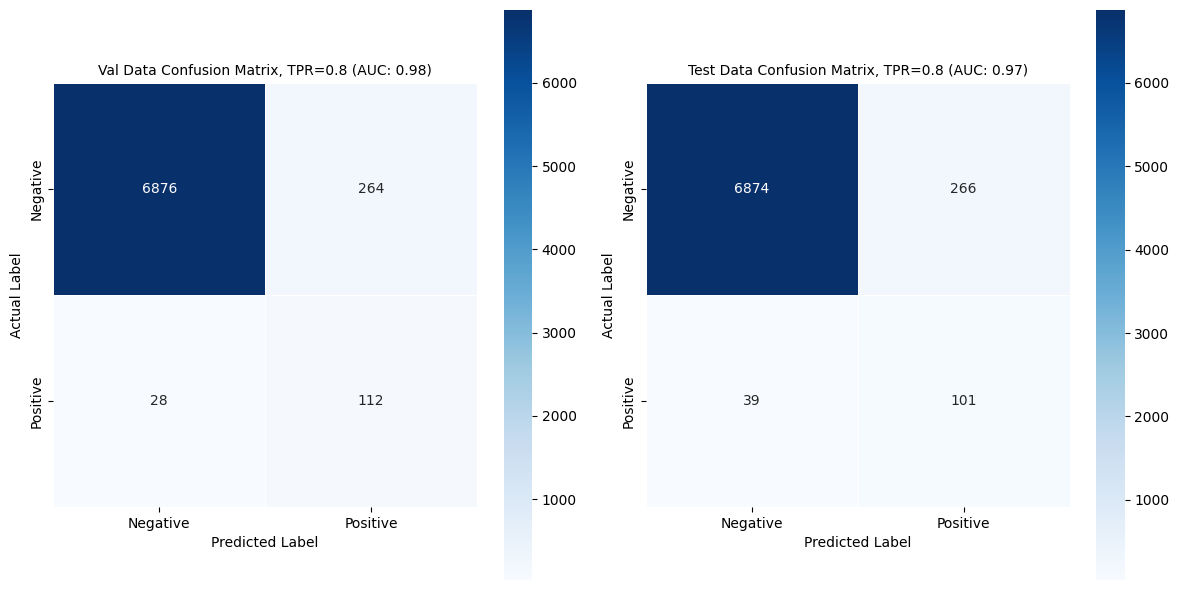

	- FPR Target: 0.05
		- Validation Accuracy: 0.948489010989011
		- Validation Specificity: 0.95
		- Test Accuracy: 0.9423076923076923
		- Test Specificity: 0.9445378151260504


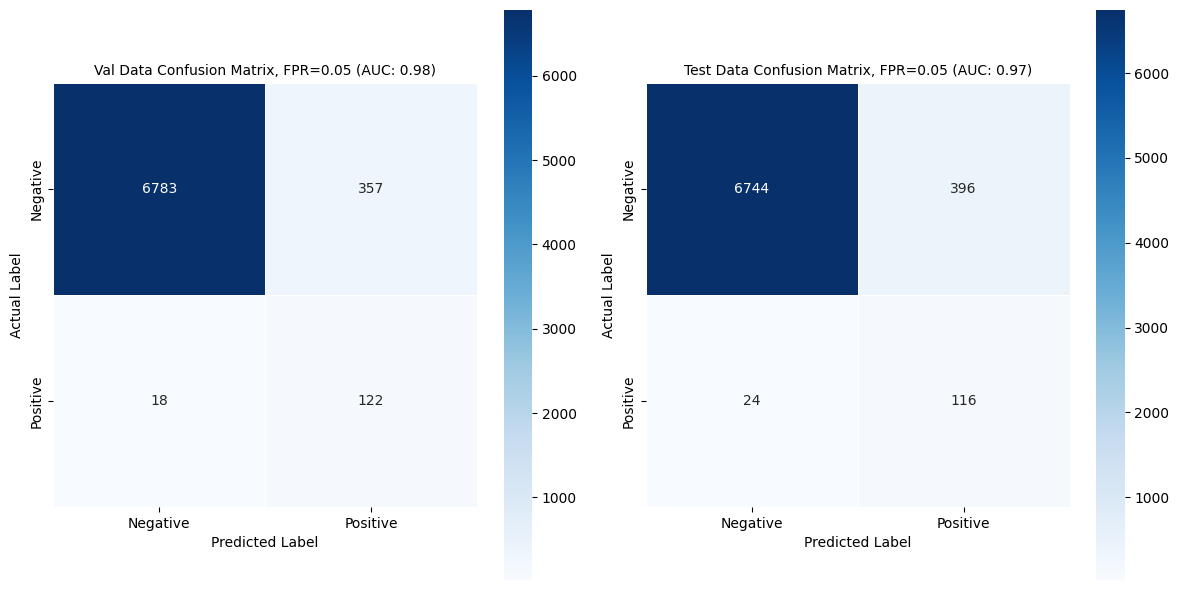

In [ ]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9651640656262506, 'loss': 5.978006636723876}
1 -> {'train': {'loss': 57.53388241492212}, 'val': {'auc': 0.7318712484993999, 'loss': 10.858940675854683}, 'secondval': {'auc': 0.7088490396158464, 'loss': 10.85893782787025}}
2 -> {'train': {'loss': 32.57186942733824}, 'val': {'auc': 0.8056597639055622, 'loss': 10.855620274320245}, 'secondval': {'auc': 0.8121133453381354, 'loss': 10.85566333681345}}
3 -> {'train': {'loss': 32.75400694552809}, 'val': {'auc': 0.7763175270108044, 'loss': 10.87145309895277}, 'secondval': {'auc': 0.7532558023209285, 'loss': 10.871564263477921}}
4 -> {'train': {'loss': 32.774476449005306}, 'val': {'auc': 0.7771903761504602, 'loss': 10.86910799331963}, 'secondval': {'auc': 0.7590881352541017, 'loss': 10.869840754196048}}
5 -> {'train': {'loss': 32.4274910595268}, 'val': {'auc': 0.8055407162865145, 'loss': 10.86115299910307}, 'secondval': {'auc': 0.8053526410564225, 'loss': 10.865777153521776}}
6 -> {'train': {'loss': 30.592923680320382}, 'val': 

##### Experiment #12

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [13:14<00:00,  7.95s/it]


	- Best Val AUC Epoch: 100
	- Best Val AUC: 0.9665686274509804
	- Best Test AUC: 0.9545488195278112


	- TPR Target: 0.8
		- Validation Accuracy: 0.959478021978022
		- Validation Recall: 0.8
		- Test Accuracy: 0.9563186813186814
		- Test Recall: 0.7


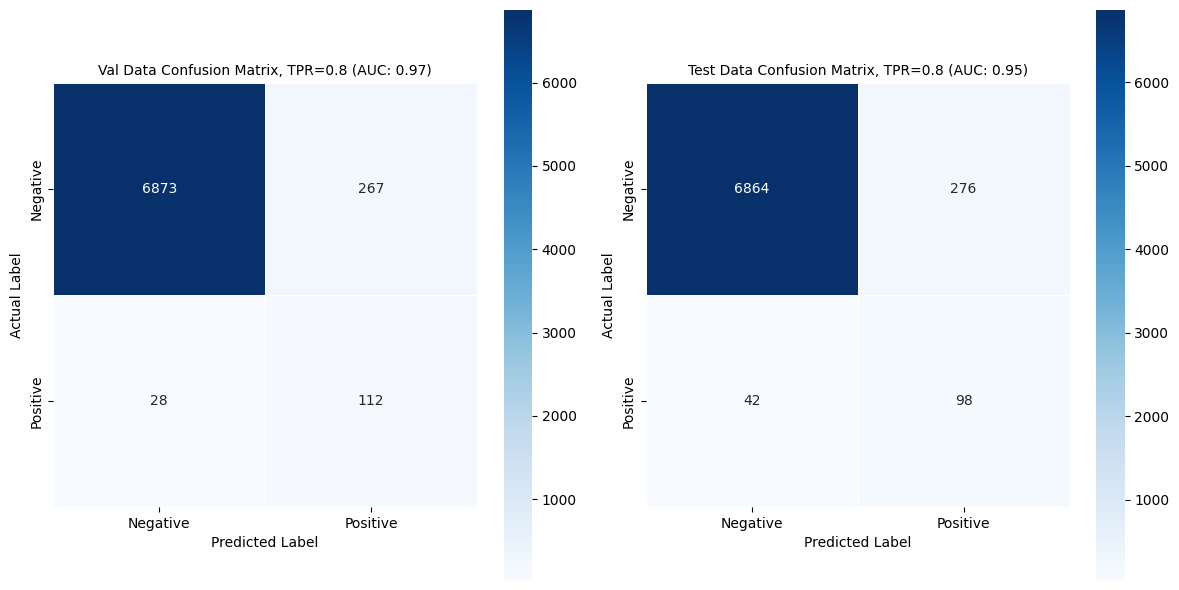

	- FPR Target: 0.05
		- Validation Accuracy: 0.946565934065934
		- Validation Specificity: 0.9484593837535014
		- Test Accuracy: 0.9427197802197802
		- Test Specificity: 0.9457983193277311


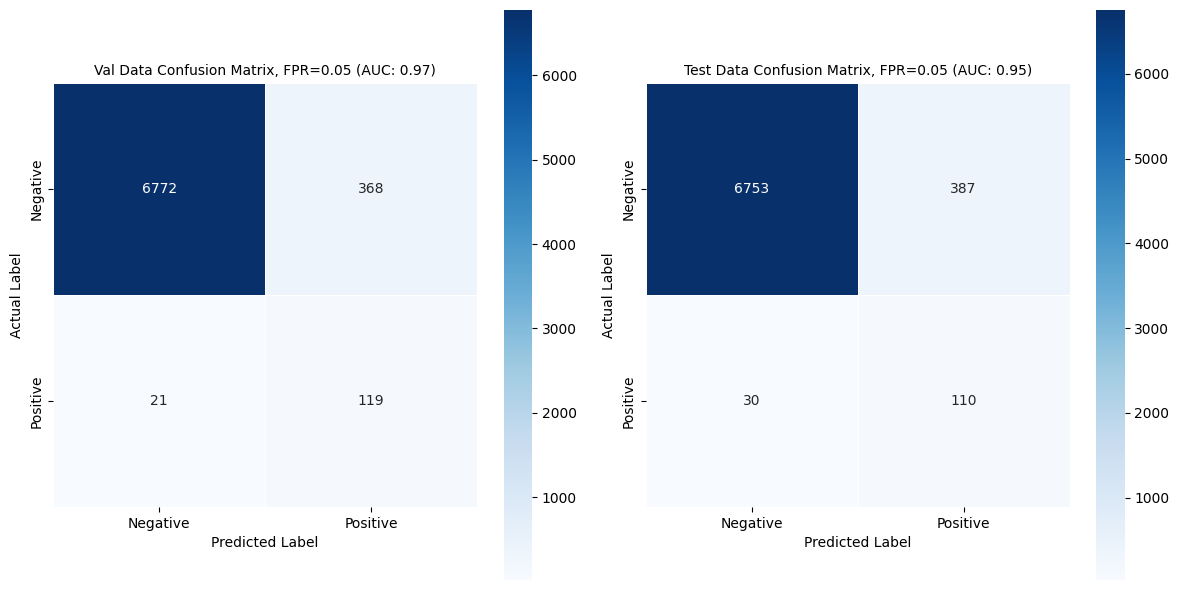

In [ ]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9545488195278112, 'loss': 6.317580059636384}
1 -> {'train': {'loss': 73.43475840054452}, 'val': {'auc': 0.8516201480592236, 'loss': 10.85515646263957}, 'secondval': {'auc': 0.8386504601840736, 'loss': 10.855244658887386}}
2 -> {'train': {'loss': 32.530994759872556}, 'val': {'auc': 0.8036399559823928, 'loss': 10.755821758881211}, 'secondval': {'auc': 0.8242176870748299, 'loss': 10.77479125186801}}
3 -> {'train': {'loss': 32.39871932566166}, 'val': {'auc': 0.8312389955982393, 'loss': 10.558158904314041}, 'secondval': {'auc': 0.8538555422168868, 'loss': 10.610339485108852}}
4 -> {'train': {'loss': 31.247553998604417}, 'val': {'auc': 0.7732092837134854, 'loss': 10.849811874330044}, 'secondval': {'auc': 0.8109633853541417, 'loss': 10.852458003908396}}
5 -> {'train': {'loss': 32.1429031630978}, 'val': {'auc': 0.7984573829531812, 'loss': 10.982571182772517}, 'secondval': {'auc': 0.8188425370148059, 'loss': 10.98702570144087}}
6 -> {'train': {'loss': 31.703253087587655}, 'val

##### Experiment #19

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [19:12<00:00, 11.53s/it]


	- Best Val AUC Epoch: 87
	- Best Val AUC: 0.9477320928371349
	- Best Test AUC: 0.9124799919967987


	- TPR Target: 0.8
		- Validation Accuracy: 0.9156593406593406
		- Validation Recall: 0.8071428571428572
		- Test Accuracy: 0.9174450549450549
		- Test Recall: 0.6785714285714286


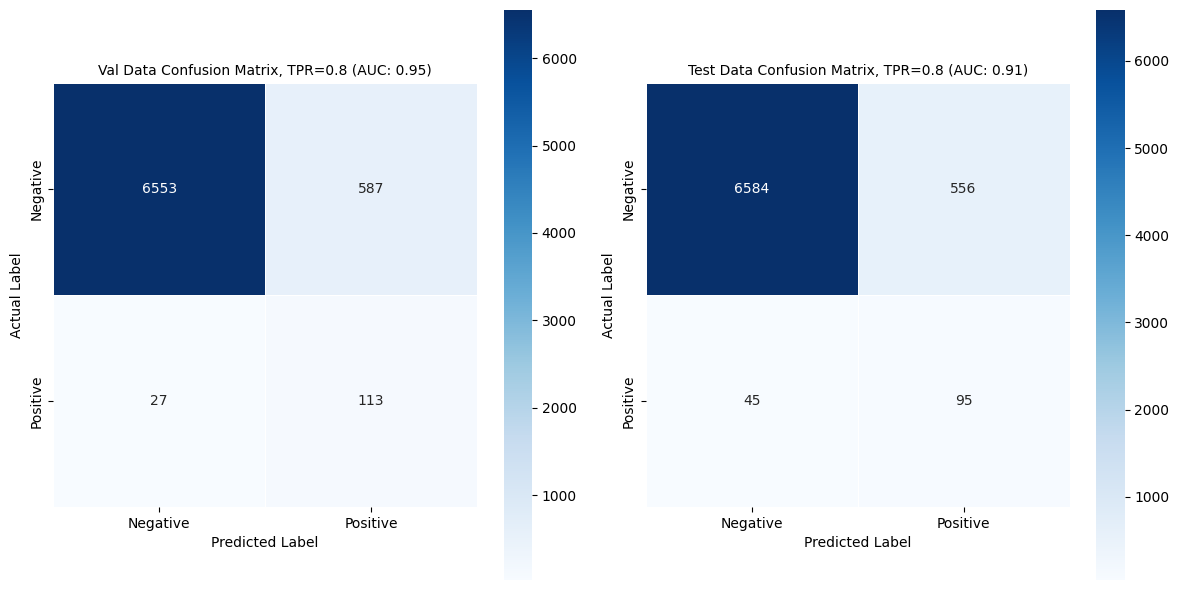

	- FPR Target: 0.05
		- Validation Accuracy: 0.9460164835164835
		- Validation Specificity: 0.9508403361344537
		- Test Accuracy: 0.9504120879120879
		- Test Specificity: 0.9582633053221289


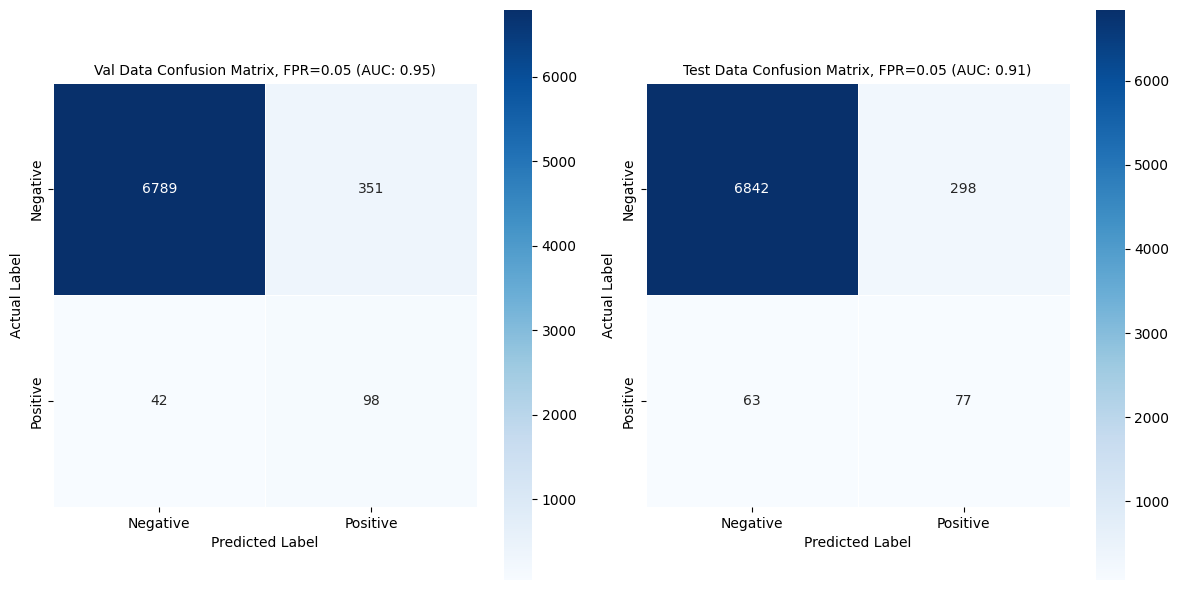

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9124799919967987, 'loss': 7.596504691056907}
1 -> {'train': {'loss': 65.36311277002096}, 'val': {'auc': 0.8061229491796719, 'loss': 10.823897667229176}, 'secondval': {'auc': 0.7933343337334933, 'loss': 10.828337019309402}}
2 -> {'train': {'loss': 30.745148684829473}, 'val': {'auc': 0.8921138455382153, 'loss': 10.007108774036169}, 'secondval': {'auc': 0.8805632252901161, 'loss': 10.424541644752026}}
3 -> {'train': {'loss': 27.64096913067624}, 'val': {'auc': 0.885171068427371, 'loss': 8.184820135124028}, 'secondval': {'auc': 0.8802160864345738, 'loss': 8.83410934265703}}
4 -> {'train': {'loss': 25.821607787627727}, 'val': {'auc': 0.9151150460184074, 'loss': 7.6143704270944}, 'secondval': {'auc': 0.894796918767507, 'loss': 8.04463609866798}}
5 -> {'train': {'loss': 26.041768457274884}, 'val': {'auc': 0.9009973989595839, 'loss': 7.863431966397911}, 'secondval': {'auc': 0.8959093637454982, 'loss': 8.467358692549169}}
6 -> {'train': {'loss': 25.285933557432145}, 'val': {'au

##### Experiment #20

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [20:08<00:00, 12.08s/it]


	- Best Val AUC Epoch: 46
	- Best Val AUC: 0.999593837535014
	- Best Test AUC: 0.9994897959183674


	- TPR Target: 0.8
		- Validation Accuracy: 0.9950549450549451
		- Validation Recall: 0.7714285714285715
		- Test Accuracy: 0.998489010989011
		- Test Recall: 1.0


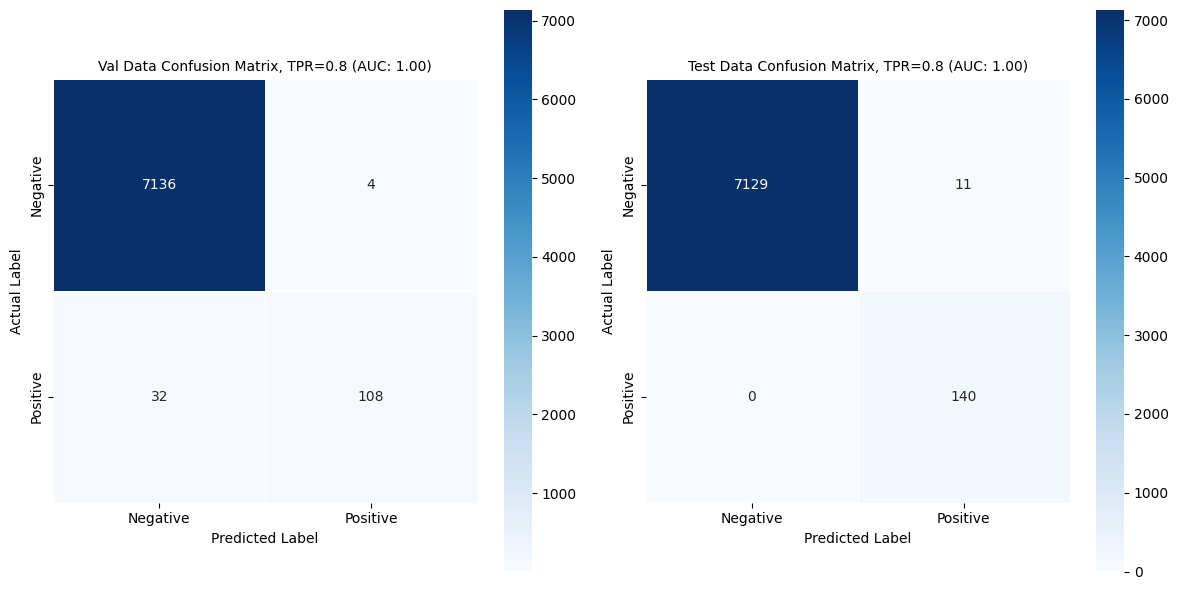

	- FPR Target: 0.05
		- Validation Accuracy: 0.996978021978022
		- Validation Specificity: 0.9970588235294118
		- Test Accuracy: 0.9973901098901099
		- Test Specificity: 0.9973389355742297


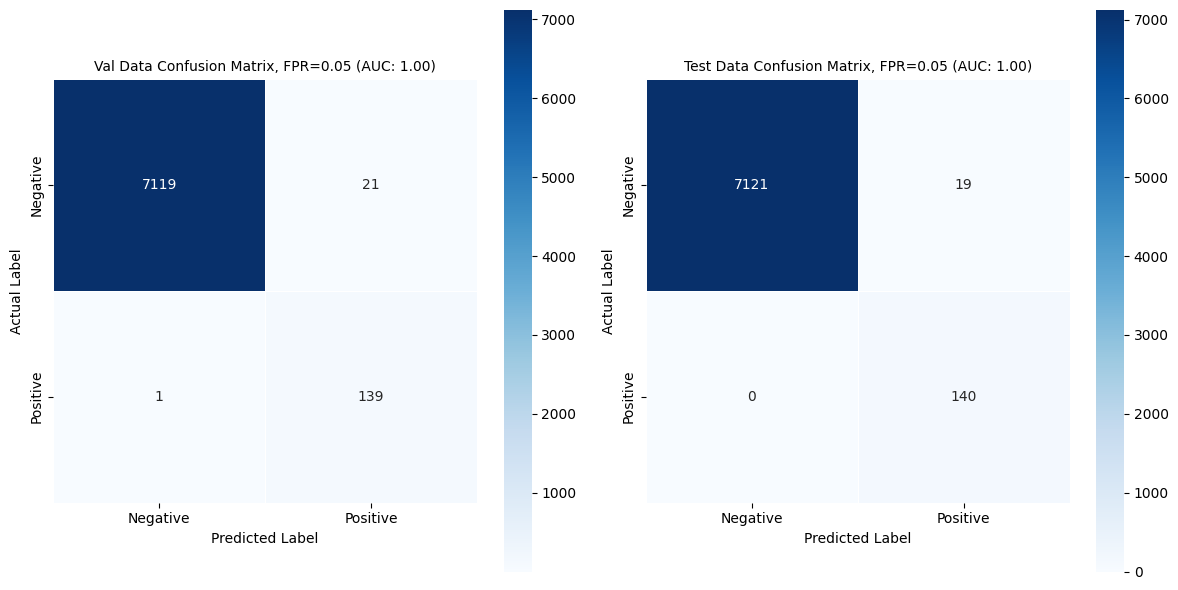

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9994897959183674, 'loss': 0.6314795816870173}
1 -> {'train': {'loss': 52.46919562108815}, 'val': {'auc': 0.8457117847138855, 'loss': 10.797034220770001}, 'secondval': {'auc': 0.827844137655062, 'loss': 10.813743628561497}}
2 -> {'train': {'loss': 30.34250110760331}, 'val': {'auc': 0.8799044617847138, 'loss': 9.153865070547909}, 'secondval': {'auc': 0.8340656262505002, 'loss': 9.537941934075207}}
3 -> {'train': {'loss': 27.382208090741187}, 'val': {'auc': 0.8906257503001201, 'loss': 8.771810220554471}, 'secondval': {'auc': 0.8434633853541417, 'loss': 9.242593286558986}}
4 -> {'train': {'loss': 26.14441192476079}, 'val': {'auc': 0.8909723889555822, 'loss': 8.083687319420278}, 'secondval': {'auc': 0.8508383353341337, 'loss': 8.627735397778451}}
5 -> {'train': {'loss': 26.067902914248407}, 'val': {'auc': 0.9053521408563427, 'loss': 7.93482628185302}, 'secondval': {'auc': 0.8506352541016406, 'loss': 8.580043859779835}}
6 -> {'train': {'loss': 26.029661759268492}, 'val': {'

##### Experiment #25

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:55<00:00, 11.36s/it]


	- Best Val AUC Epoch: 96
	- Best Val AUC: 0.999811924769908
	- Best Test AUC: 0.9998569427771107


	- TPR Target: 0.8
		- Validation Accuracy: 0.9978021978021978
		- Validation Recall: 0.9
		- Test Accuracy: 0.9986263736263736
		- Test Recall: 0.9928571428571429


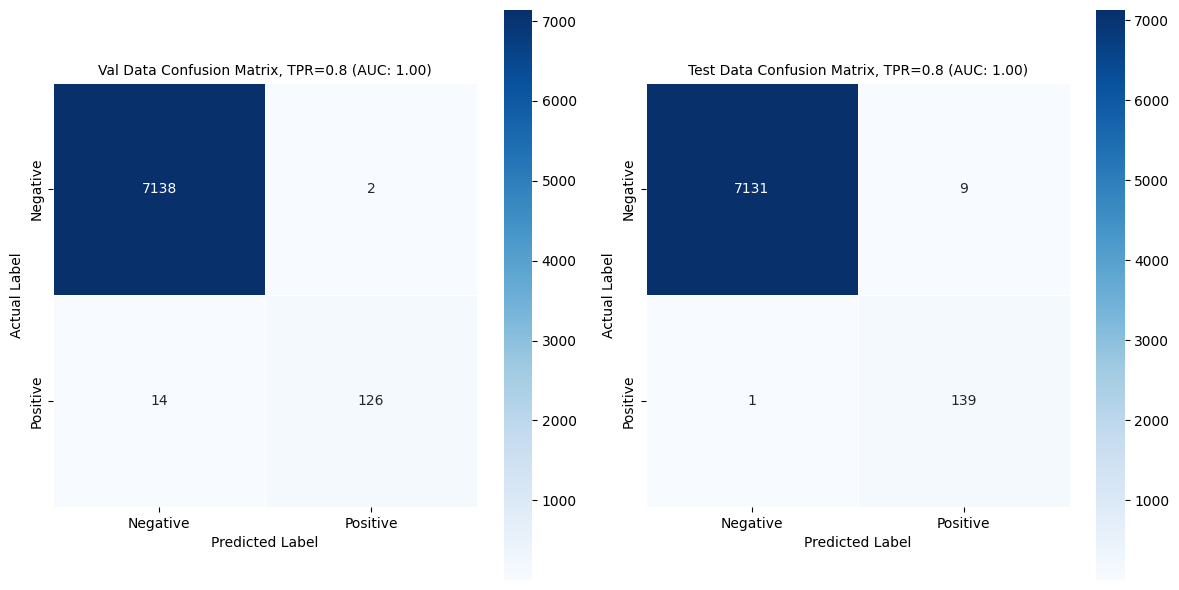

	- FPR Target: 0.05
		- Validation Accuracy: 0.9983516483516484
		- Validation Specificity: 0.9985994397759104
		- Test Accuracy: 0.9962912087912088
		- Test Specificity: 0.996218487394958


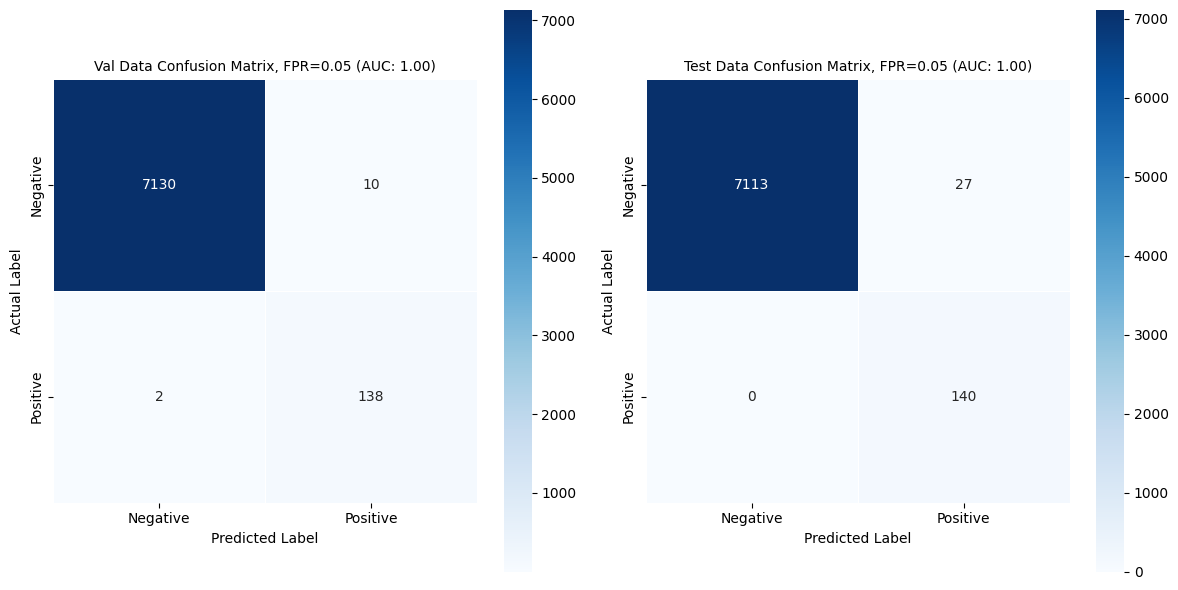

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0001
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9998569427771107, 'loss': 0.5726921144523658}
1 -> {'train': {'loss': 163.9781039059162}, 'val': {'auc': 0.8499819927971188, 'loss': 31.487281024456024}, 'secondval': {'auc': 0.8679656862745098, 'loss': 31.49322137236595}}
2 -> {'train': {'loss': 64.17248893529177}, 'val': {'auc': 0.8826705682272908, 'loss': 15.414941720664501}, 'secondval': {'auc': 0.8719187675070028, 'loss': 15.41902057081461}}
3 -> {'train': {'loss': 40.42292808741331}, 'val': {'auc': 0.8986384553821529, 'loss': 12.123226128518581}, 'secondval': {'auc': 0.8859783913565427, 'loss': 12.126815635710955}}
4 -> {'train': {'loss': 34.89266614988446}, 'val': {'auc': 0.8932052821128452, 'loss': 11.1861167922616}, 'secondval': {'auc': 0.8938715486194478, 'loss': 11.189064998179674}}
5 -> {'train': {'loss': 33.24366629682481}, 'val': {'auc': 0.878857543017207, 'loss': 10.917484603822231}, 'secondval': {'auc': 0.8917957182873149, 'loss': 10.919608743861318}}
6 -> {'train': {'loss': 32.573940662667155}, 'val':

##### Experiment #26

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [19:10<00:00, 11.50s/it]


	- Best Val AUC Epoch: 61
	- Best Val AUC: 0.9998969587835135
	- Best Test AUC: 0.9997939175670268


	- TPR Target: 0.8
		- Validation Accuracy: 0.9989010989010989
		- Validation Recall: 0.95
		- Test Accuracy: 0.998489010989011
		- Test Recall: 0.9571428571428572


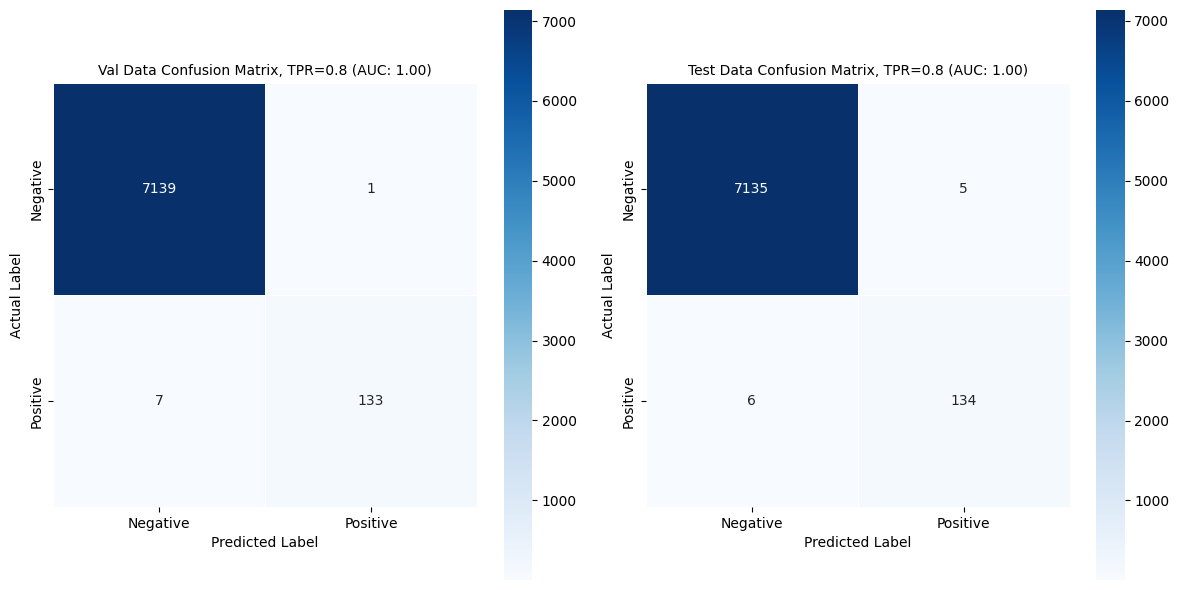

	- FPR Target: 0.05
		- Validation Accuracy: 0.9991758241758242
		- Validation Specificity: 0.9992997198879552
		- Test Accuracy: 0.9986263736263736
		- Test Specificity: 0.9985994397759104


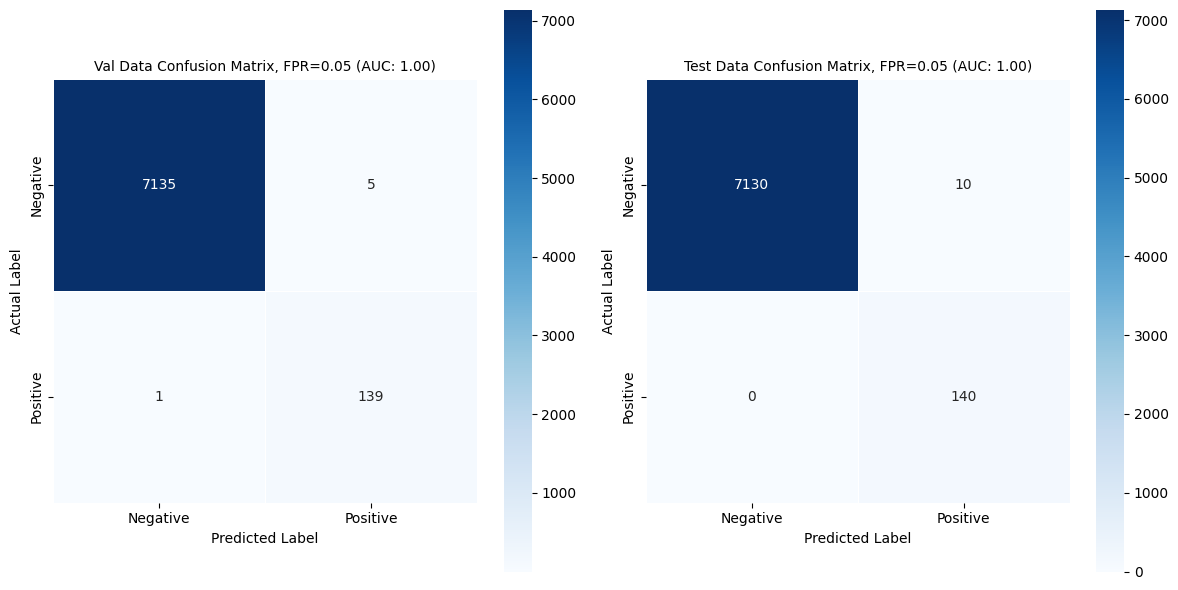

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9997939175670268, 'loss': 0.5531418914197275}
1 -> {'train': {'loss': 58.42278239503503}, 'val': {'auc': 0.8612329931972789, 'loss': 10.715569477528334}, 'secondval': {'auc': 0.8172153861544618, 'loss': 10.73273454234004}}
2 -> {'train': {'loss': 28.466202070005238}, 'val': {'auc': 0.8610029011604642, 'loss': 9.08301346283406}, 'secondval': {'auc': 0.837875150060024, 'loss': 9.519161649048328}}
3 -> {'train': {'loss': 26.808074481319636}, 'val': {'auc': 0.8892727090836335, 'loss': 8.091556341387331}, 'secondval': {'auc': 0.875328631452581, 'loss': 8.527602440677583}}
4 -> {'train': {'loss': 25.682858149986714}, 'val': {'auc': 0.8953881552621048, 'loss': 7.867370224557817}, 'secondval': {'auc': 0.86312725090036, 'loss': 8.315259095281363}}
5 -> {'train': {'loss': 25.486204164102674}, 'val': {'auc': 0.909499799919968, 'loss': 7.89232782041654}, 'secondval': {'auc': 0.8905352140856343, 'loss': 8.418540718965232}}
6 -> {'train': {'loss': 25.690113154239953}, 'val': {'auc'

##### Experiment #27

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [23:02<00:00, 13.83s/it]


	- Best Val AUC Epoch: 45
	- Best Val AUC: 0.7483003201280513
	- Best Test AUC: 0.5


	- TPR Target: 0.8
		- Validation Accuracy: 0.6872252747252747
		- Validation Recall: 0.6857142857142857
		- Test Accuracy: 0.019230769230769232
		- Test Recall: 1.0


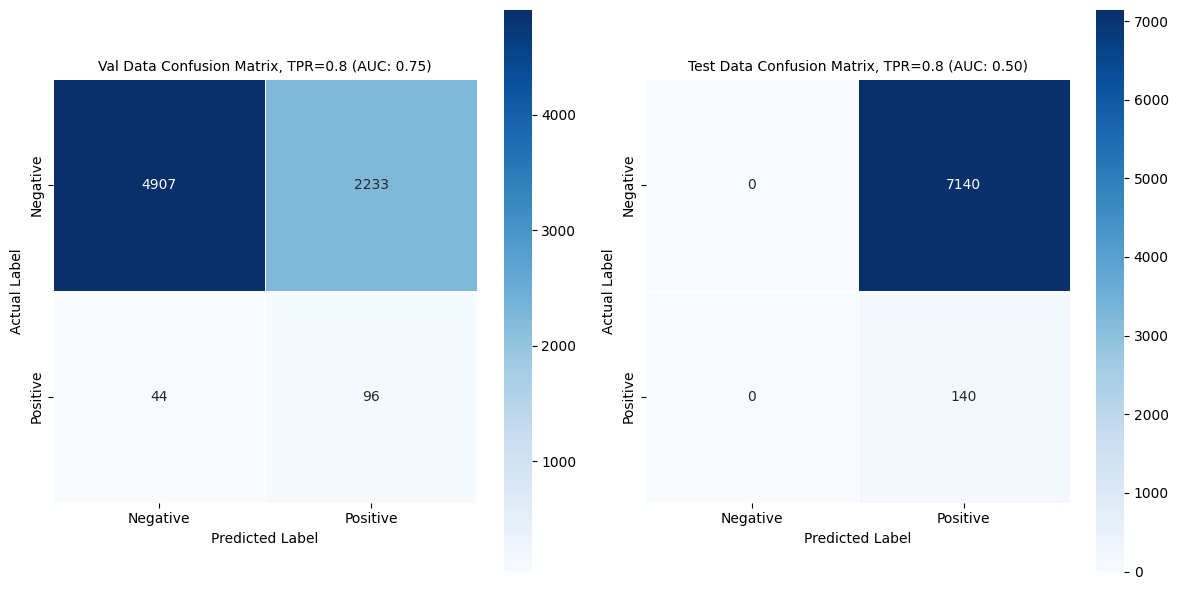

	- FPR Target: 0.05
		- Validation Accuracy: 0.9379120879120879
		- Validation Specificity: 0.949859943977591
		- Test Accuracy: 0.019230769230769232
		- Test Specificity: 0.0


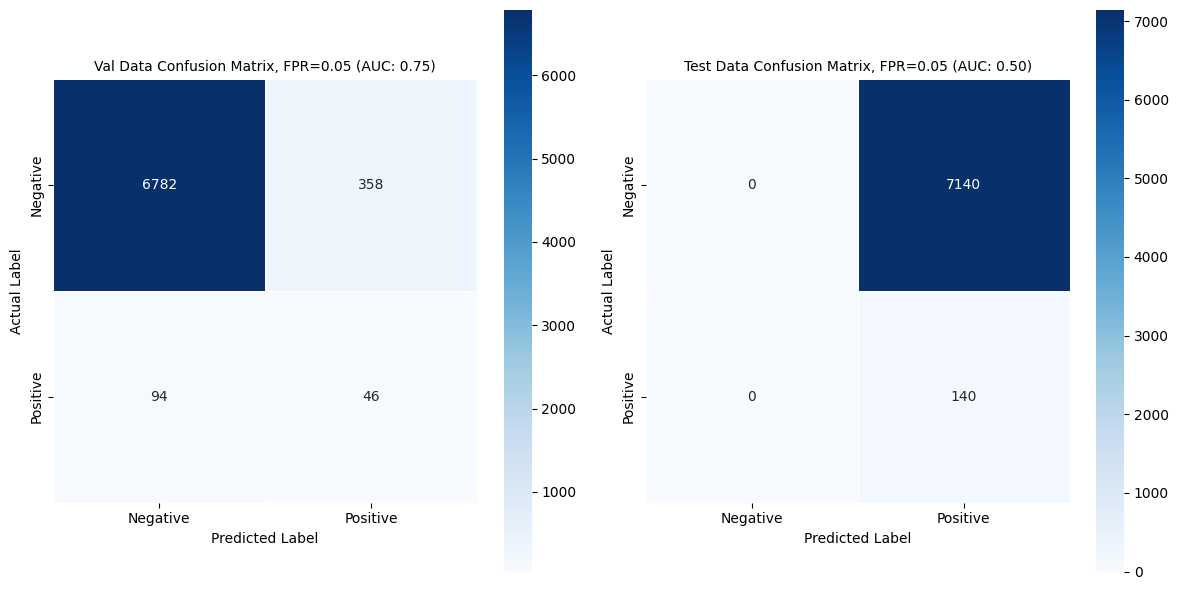

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.01
batch_size = 64
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.5, 'loss': 10.858947362750769}
1 -> {'train': {'loss': 37.29546448169276}, 'val': {'auc': 0.5, 'loss': 10.886928144842386}, 'secondval': {'auc': 0.5, 'loss': 10.886928137391806}}
2 -> {'train': {'loss': 32.84240653831512}, 'val': {'auc': 0.5121443577430973, 'loss': 11.186211904510856}, 'secondval': {'auc': 0.4802531012404962, 'loss': 11.186212074011564}}
3 -> {'train': {'loss': 32.968048967886716}, 'val': {'auc': 0.5389535814325731, 'loss': 11.047615110874176}, 'secondval': {'auc': 0.5332432973189276, 'loss': 11.047615042887628}}
4 -> {'train': {'loss': 33.21013258676976}, 'val': {'auc': 0.48609543817527007, 'loss': 10.855522383004427}, 'secondval': {'auc': 0.49664465786314527, 'loss': 10.855522222816944}}
5 -> {'train': {'loss': 32.94455306045711}, 'val': {'auc': 0.3293472388955582, 'loss': 10.855485942214727}, 'secondval': {'auc': 0.3543342336934774, 'loss': 10.855486001819372}}
6 -> {'train': {'loss': 32.967785933986306}, 'val': {'auc': 0.4315501200480192, 'loss': 

##### Experiment #28

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:40<00:00, 11.21s/it]


	- Best Val AUC Epoch: 50
	- Best Val AUC: 0.999921968787515
	- Best Test AUC: 0.9996388555422169


	- TPR Target: 0.8
		- Validation Accuracy: 0.9967032967032967
		- Validation Recall: 0.8357142857142857
		- Test Accuracy: 0.9983516483516484
		- Test Recall: 0.95


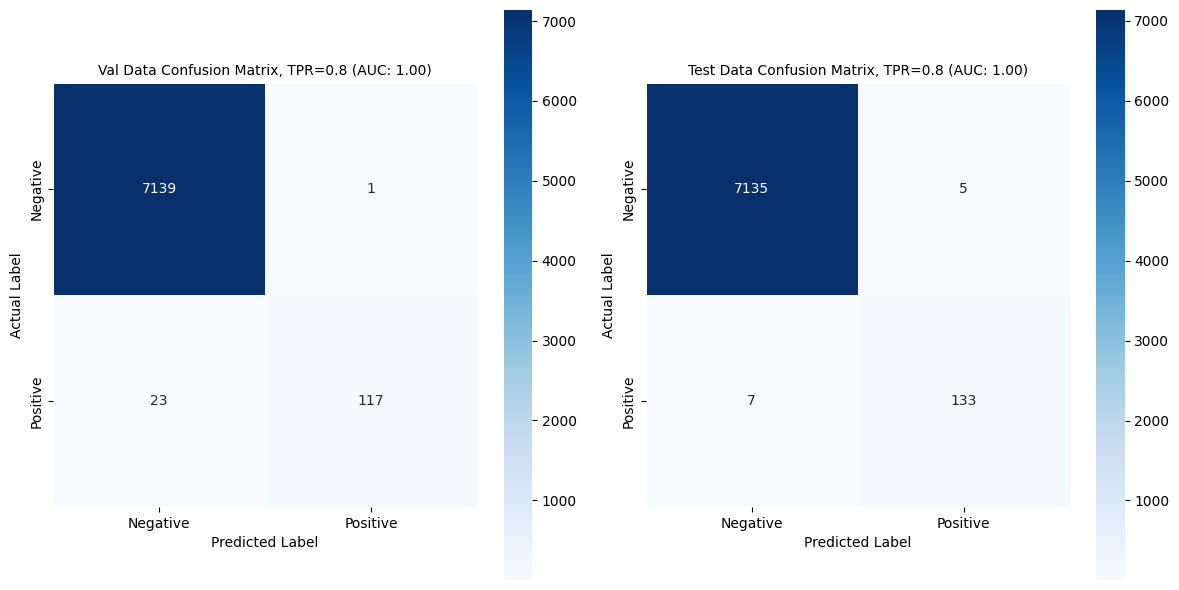

	- FPR Target: 0.05
		- Validation Accuracy: 0.9289835164835165
		- Validation Specificity: 0.9275910364145659
		- Test Accuracy: 0.9964285714285714
		- Test Specificity: 0.996358543417367


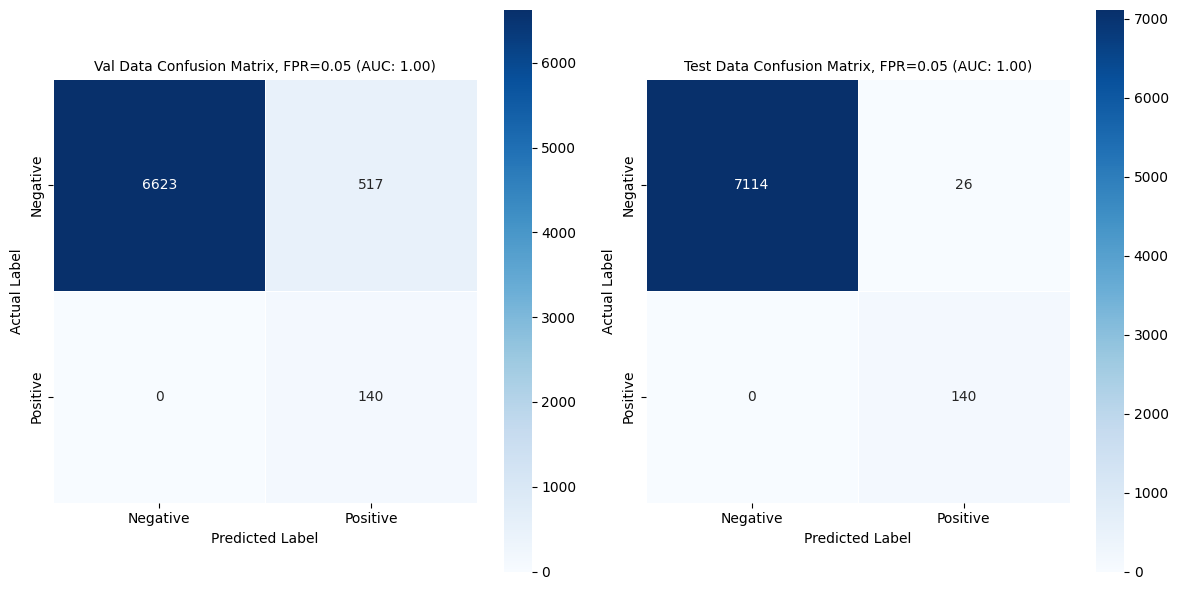

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 128
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9996388555422169, 'loss': 0.7734521840284287}
1 -> {'train': {'loss': 88.52723854593933}, 'val': {'auc': 0.8252050820328131, 'loss': 11.085890313610435}, 'secondval': {'auc': 0.7467862144857943, 'loss': 11.086102213710546}}
2 -> {'train': {'loss': 32.74031765945256}, 'val': {'auc': 0.6968917567026811, 'loss': 14.213135100901127}, 'secondval': {'auc': 0.6866436574629853, 'loss': 13.997947927564383}}
3 -> {'train': {'loss': 30.089959521777928}, 'val': {'auc': 0.7749529811924769, 'loss': 9.387764418497682}, 'secondval': {'auc': 0.7508153261304521, 'loss': 9.595993688330054}}
4 -> {'train': {'loss': 28.340952324680984}, 'val': {'auc': 0.7945733293317326, 'loss': 8.883418624289334}, 'secondval': {'auc': 0.7758363345338136, 'loss': 9.281350678764284}}
5 -> {'train': {'loss': 28.05048035737127}, 'val': {'auc': 0.7930992396958785, 'loss': 8.82277546543628}, 'secondval': {'auc': 0.774733893557423, 'loss': 9.22524118795991}}
6 -> {'train': {'loss': 27.74942933395505}, 'val': {'

##### Experiment #29

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:26<00:00, 11.07s/it]


	- Best Val AUC Epoch: 71
	- Best Val AUC: 0.9998499399759904
	- Best Test AUC: 0.9996428571428572


	- TPR Target: 0.8
		- Validation Accuracy: 0.9973901098901099
		- Validation Recall: 0.8714285714285714
		- Test Accuracy: 0.9839285714285714
		- Test Recall: 0.17142857142857143


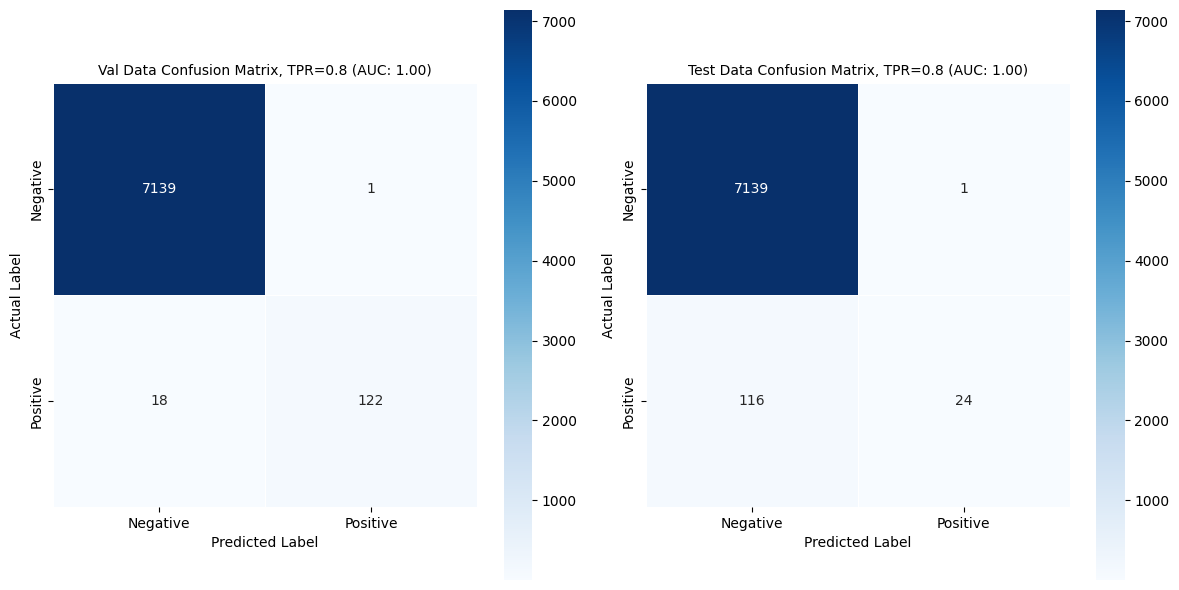

	- FPR Target: 0.05
		- Validation Accuracy: 0.998489010989011
		- Validation Specificity: 0.9985994397759104
		- Test Accuracy: 0.9899725274725275
		- Test Specificity: 0.9997198879551821


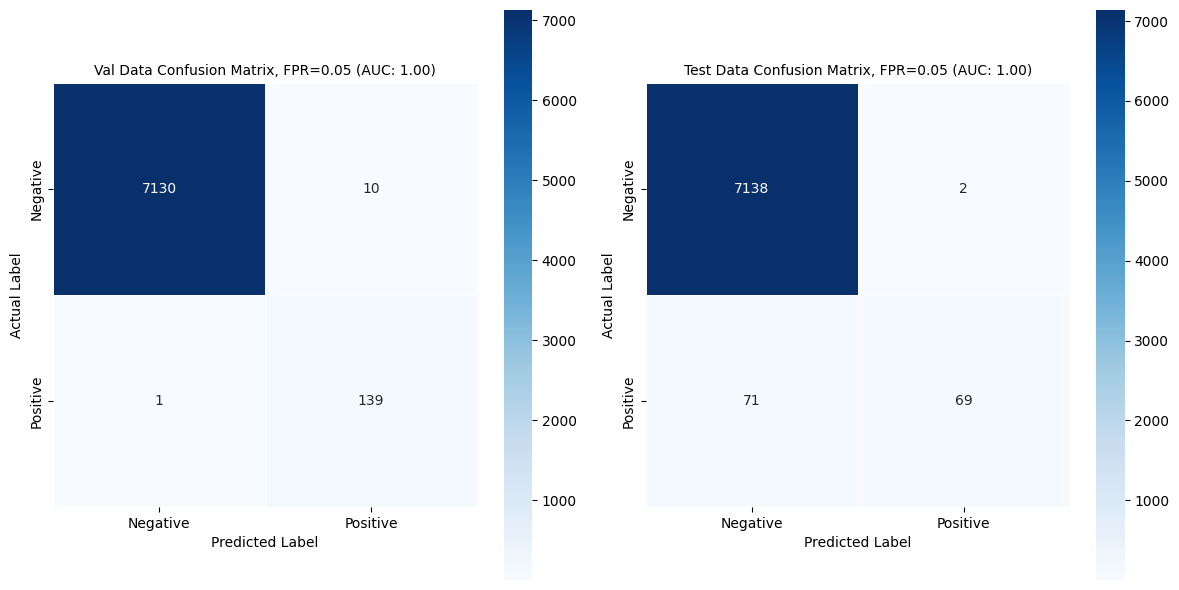

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 256
rnn_dropout = 0.10
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9996428571428572, 'loss': 1.2689723795992904}
1 -> {'train': {'loss': 74.5900389496237}, 'val': {'auc': 0.836265006002401, 'loss': 10.854914890602231}, 'secondval': {'auc': 0.8380437174869948, 'loss': 10.857274500653148}}
2 -> {'train': {'loss': 31.7041320130229}, 'val': {'auc': 0.8509493797519008, 'loss': 8.92256810516119}, 'secondval': {'auc': 0.8484908963585435, 'loss': 9.27521562948823}}
3 -> {'train': {'loss': 28.653945670463145}, 'val': {'auc': 0.8435254101640656, 'loss': 9.011978777125478}, 'secondval': {'auc': 0.8510404161664666, 'loss': 9.31664709188044}}
4 -> {'train': {'loss': 28.271948661655188}, 'val': {'auc': 0.8431317527010804, 'loss': 8.76383272279054}, 'secondval': {'auc': 0.8471978791516606, 'loss': 9.272118150256574}}
5 -> {'train': {'loss': 28.36468775756657}, 'val': {'auc': 0.8473089235694278, 'loss': 8.862554569728673}, 'secondval': {'auc': 0.8547939175670268, 'loss': 9.161409537307918}}
6 -> {'train': {'loss': 27.007492870092392}, 'val': {'auc':

##### Experiment #30

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [16:13<00:00,  9.74s/it]


	- Best Val AUC Epoch: 99
	- Best Val AUC: 0.9998219287715087
	- Best Test AUC: 0.9997168867547018


	- TPR Target: 0.8
		- Validation Accuracy: 0.9987637362637363
		- Validation Recall: 0.95
		- Test Accuracy: 0.9986263736263736
		- Test Recall: 0.9928571428571429


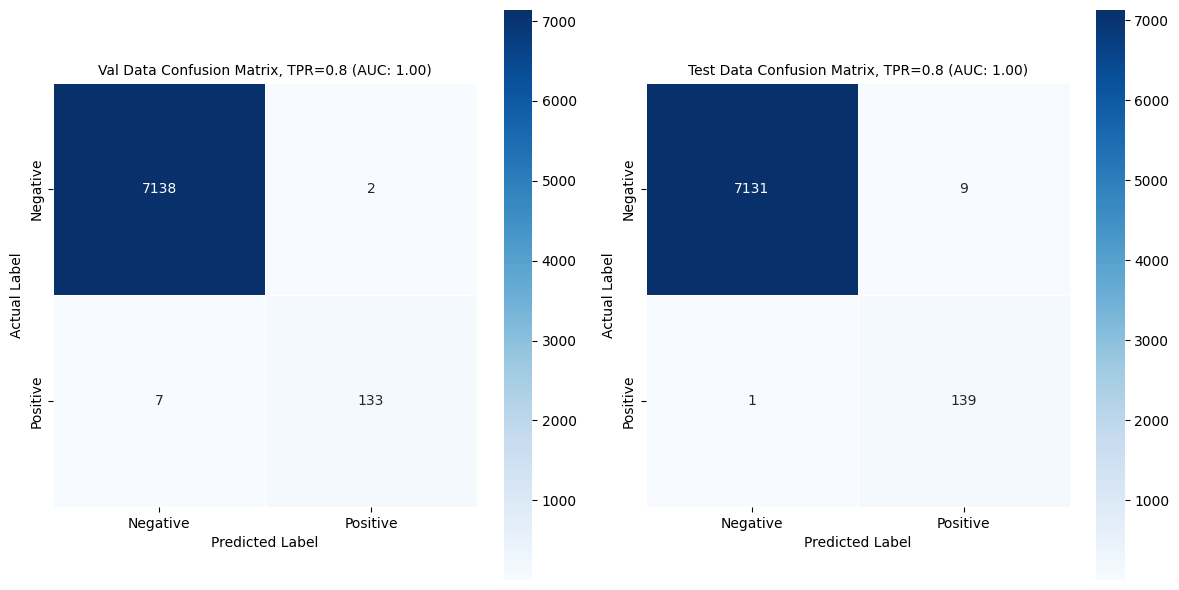

	- FPR Target: 0.05
		- Validation Accuracy: 0.9979395604395604
		- Validation Specificity: 0.9983193277310924
		- Test Accuracy: 0.9983516483516484
		- Test Specificity: 0.9983193277310924


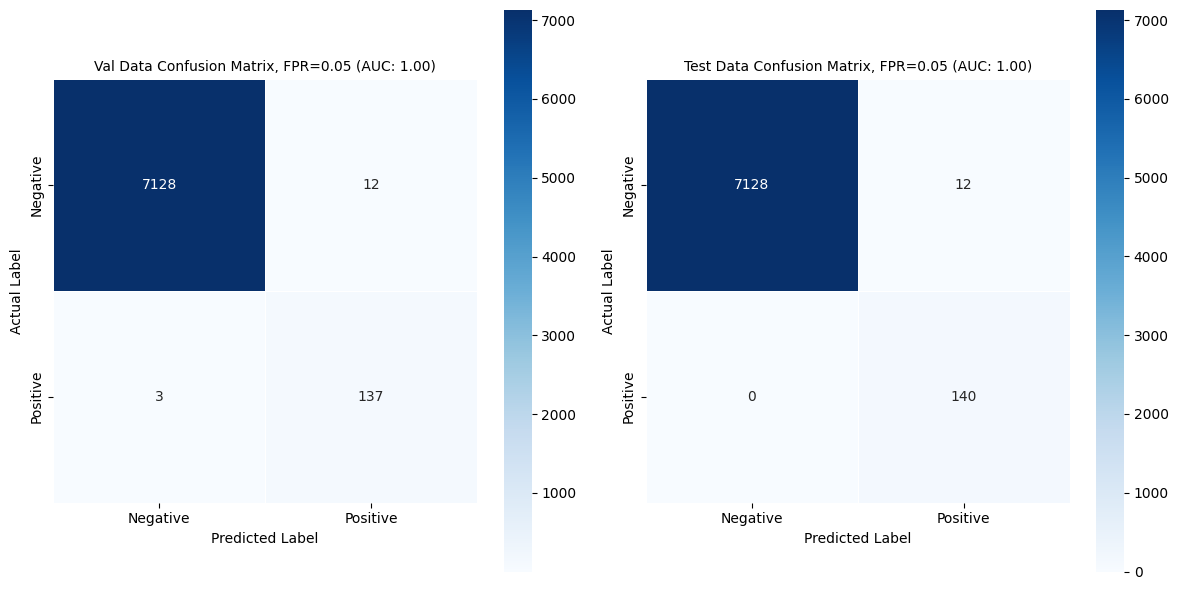

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.00
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9997168867547018, 'loss': 0.730002401081947}
1 -> {'train': {'loss': 63.22163503430784}, 'val': {'auc': 0.929093137254902, 'loss': 10.883696122094989}, 'secondval': {'auc': 0.8954546818727491, 'loss': 10.889200825244188}}
2 -> {'train': {'loss': 30.11339546740055}, 'val': {'auc': 0.8928666466586634, 'loss': 8.693249925971031}, 'secondval': {'auc': 0.8688375350140056, 'loss': 9.069697423838079}}
3 -> {'train': {'loss': 26.89473308622837}, 'val': {'auc': 0.9071578631452581, 'loss': 8.24406560510397}, 'secondval': {'auc': 0.8634203681472589, 'loss': 8.863226518034935}}
4 -> {'train': {'loss': 25.543040917254984}, 'val': {'auc': 0.9020968387354942, 'loss': 8.631774599198252}, 'secondval': {'auc': 0.8769092637054823, 'loss': 9.228606296237558}}
5 -> {'train': {'loss': 25.597186915576458}, 'val': {'auc': 0.907984193677471, 'loss': 7.7345489505678415}, 'secondval': {'auc': 0.8605452180872348, 'loss': 8.472455280367285}}
6 -> {'train': {'loss': 25.909867713227868}, 'val': {'a

##### Experiment #31

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [15:54<00:00,  9.54s/it]


	- Best Val AUC Epoch: 99
	- Best Val AUC: 0.9999439775910364
	- Best Test AUC: 0.9998139255702282


	- TPR Target: 0.8
		- Validation Accuracy: 0.9936813186813187
		- Validation Recall: 0.6714285714285714
		- Test Accuracy: 0.9942307692307693
		- Test Recall: 0.7142857142857143


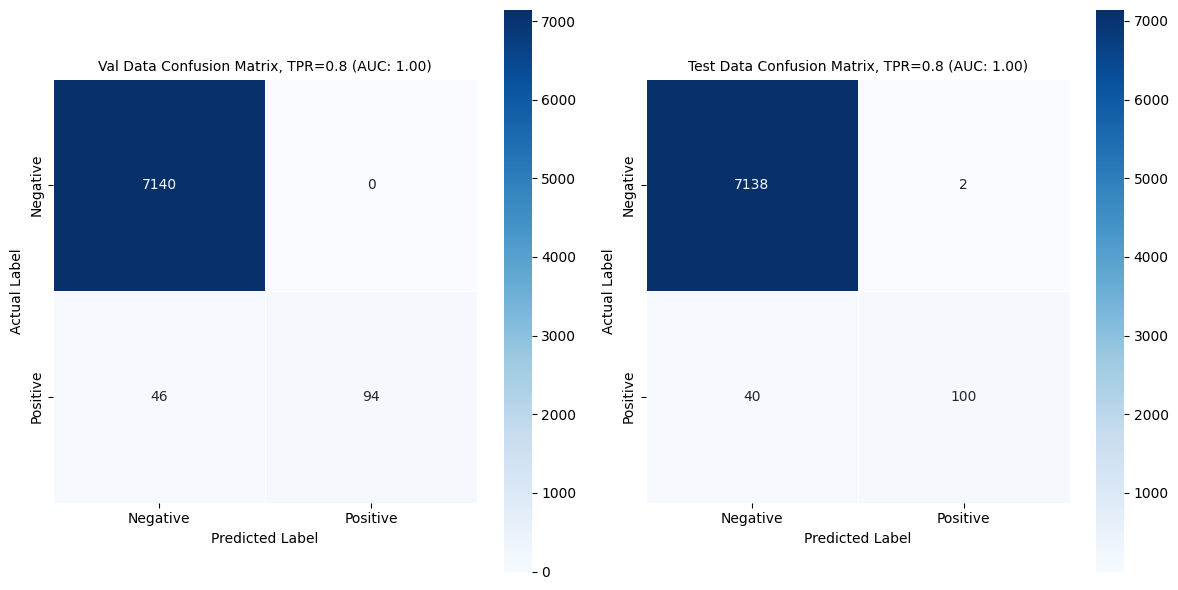

	- FPR Target: 0.05
		- Validation Accuracy: 0.9989010989010989
		- Validation Specificity: 0.9990196078431373
		- Test Accuracy: 0.998489010989011
		- Test Specificity: 0.9984593837535014


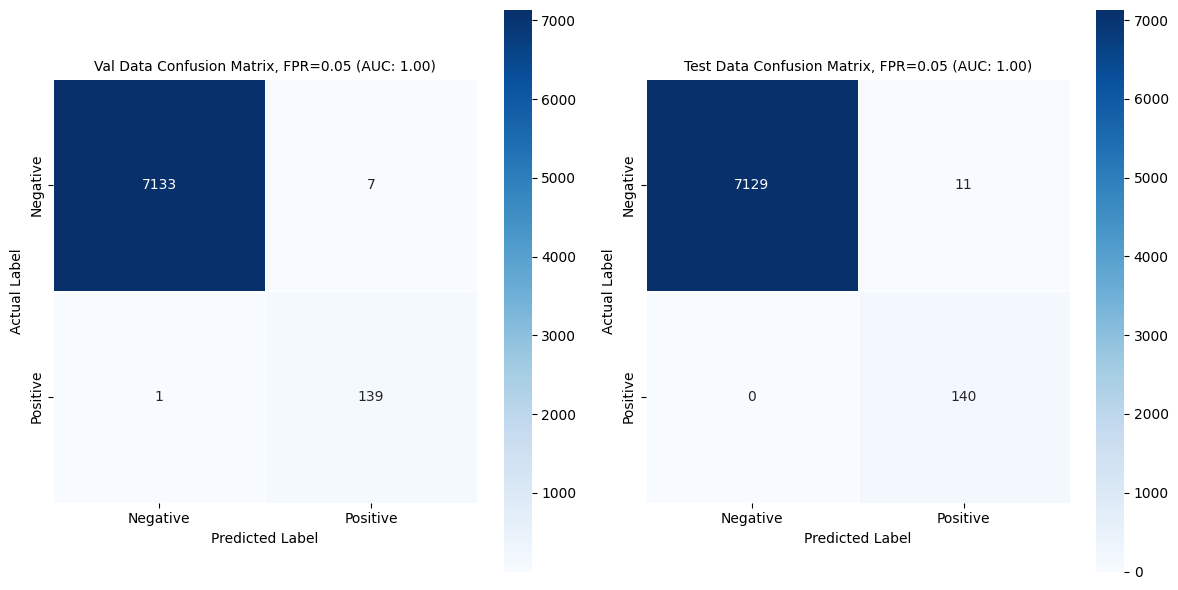

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9998139255702282, 'loss': 0.7458718973575742}
1 -> {'train': {'loss': 111.62504864856601}, 'val': {'auc': 0.2282062825130052, 'loss': 11.958527121692896}, 'secondval': {'auc': 0.25908913565426167, 'loss': 11.958512395620346}}
2 -> {'train': {'loss': 33.35423056781292}, 'val': {'auc': 0.8150105042016806, 'loss': 10.746458914130926}, 'secondval': {'auc': 0.8311184473789516, 'loss': 10.760958131402731}}
3 -> {'train': {'loss': 29.72234279010445}, 'val': {'auc': 0.8139775910364145, 'loss': 8.430662313476205}, 'secondval': {'auc': 0.8517912164865946, 'loss': 8.513072126545012}}
4 -> {'train': {'loss': 26.304705823771656}, 'val': {'auc': 0.7977831132452982, 'loss': 9.388956362381577}, 'secondval': {'auc': 0.847672569027611, 'loss': 9.673404451925308}}
5 -> {'train': {'loss': 26.00074061192572}, 'val': {'auc': 0.8109633853541416, 'loss': 7.863598375581205}, 'secondval': {'auc': 0.8371733693477391, 'loss': 8.183252302929759}}
6 -> {'train': {'loss': 25.283565470017493}, 'val'

##### Experiment #32

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [15:51<00:00,  9.52s/it]


	- Best Val AUC Epoch: 72
	- Best Val AUC: 0.9999219687875149
	- Best Test AUC: 0.9996218487394958


	- TPR Target: 0.8
		- Validation Accuracy: 0.9950549450549451
		- Validation Recall: 0.7428571428571429
		- Test Accuracy: 0.9868131868131869
		- Test Recall: 0.32857142857142857


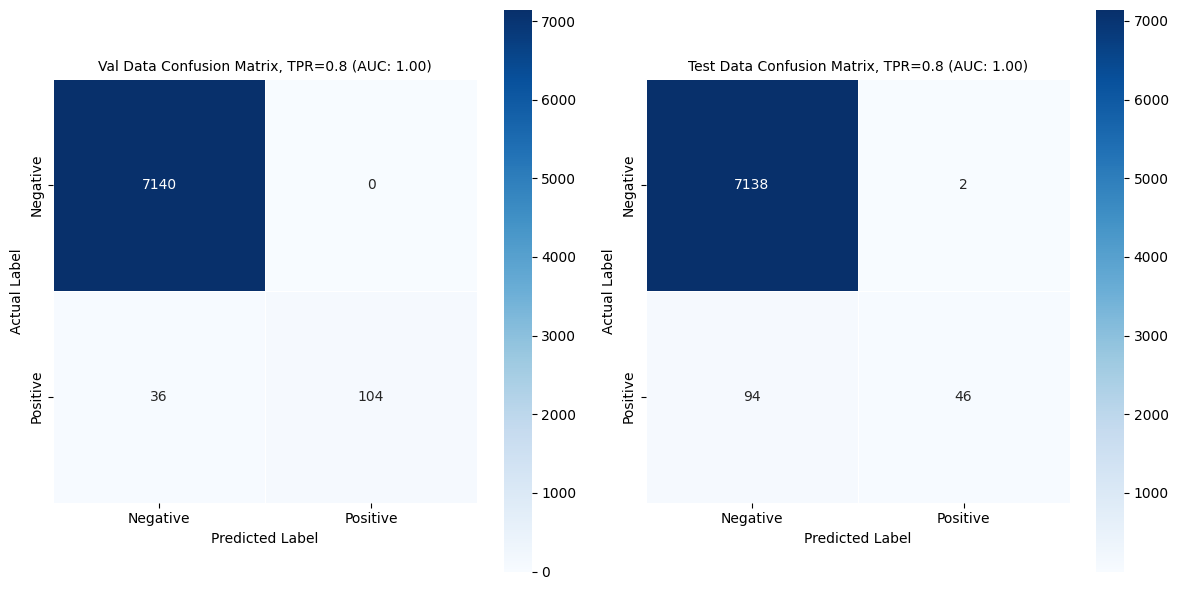

	- FPR Target: 0.05
		- Validation Accuracy: 0.9987637362637363
		- Validation Specificity: 0.9990196078431373
		- Test Accuracy: 0.9935439560439561
		- Test Specificity: 0.9995798319327731


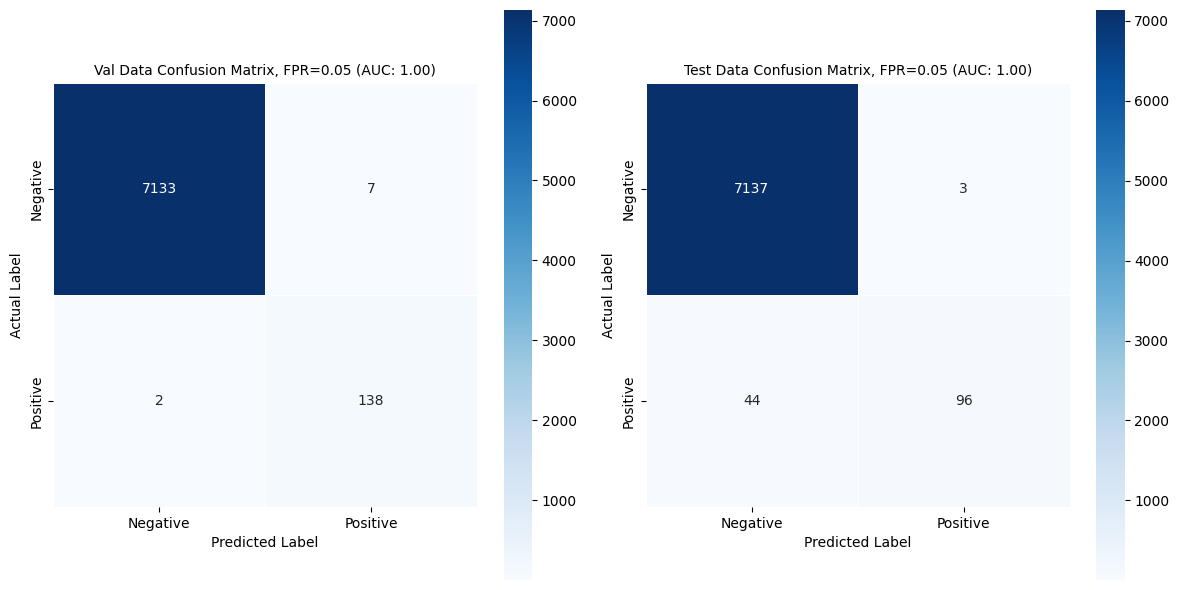

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.20
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9996218487394958, 'loss': 2.1608407988032923}
1 -> {'train': {'loss': 64.71058995462954}, 'val': {'auc': 0.8210929371748699, 'loss': 10.842098247259855}, 'secondval': {'auc': 0.8245128051220487, 'loss': 10.843498542904854}}
2 -> {'train': {'loss': 29.522497390396893}, 'val': {'auc': 0.8773179271708684, 'loss': 8.635119353421032}, 'secondval': {'auc': 0.8916506602641057, 'loss': 8.979879855178297}}
3 -> {'train': {'loss': 26.040622415021062}, 'val': {'auc': 0.9123049219687875, 'loss': 7.759254930540919}, 'secondval': {'auc': 0.9034943977591037, 'loss': 8.057274913415313}}
4 -> {'train': {'loss': 25.313120912760496}, 'val': {'auc': 0.9197569027611044, 'loss': 7.45173330232501}, 'secondval': {'auc': 0.9142612044817927, 'loss': 7.73744760453701}}
5 -> {'train': {'loss': 24.941596443299204}, 'val': {'auc': 0.9212625050020009, 'loss': 7.495116766542196}, 'secondval': {'auc': 0.9125400160064026, 'loss': 7.7437175484374166}}
6 -> {'train': {'loss': 24.74672434013337}, 'val': 

##### Experiment #33

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [15:38<00:00,  9.38s/it]


	- Best Val AUC Epoch: 45
	- Best Val AUC: 0.9997378951580632
	- Best Test AUC: 0.9996588635454181


	- TPR Target: 0.8
		- Validation Accuracy: 0.9947802197802198
		- Validation Recall: 0.75
		- Test Accuracy: 0.9842032967032966
		- Test Recall: 0.17857142857142858


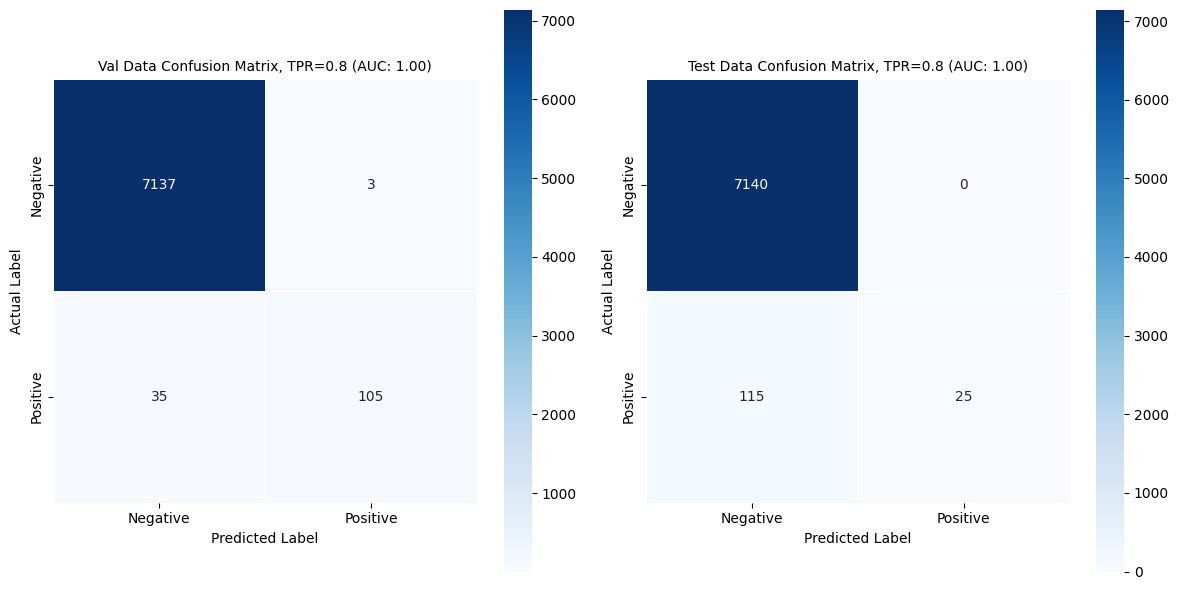

	- FPR Target: 0.05
		- Validation Accuracy: 0.9971153846153846
		- Validation Specificity: 0.9971988795518207
		- Test Accuracy: 0.9972527472527473
		- Test Specificity: 0.9991596638655462


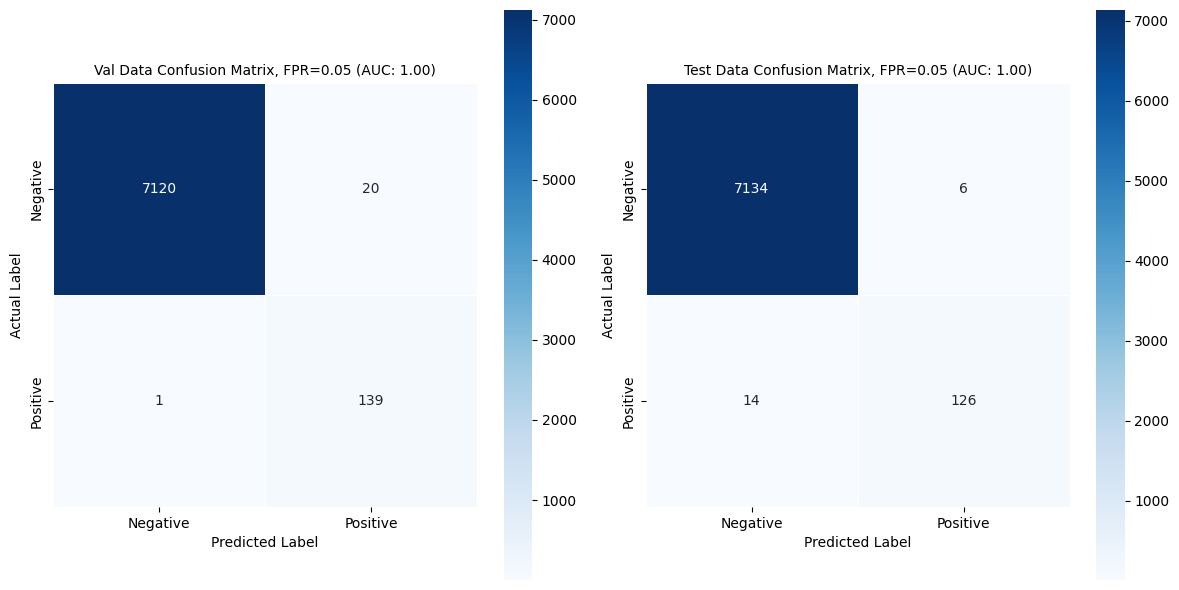

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.30
rnn_hidden_size = 16
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r.3') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

In [ ]:
for k, v in train_val_test_log.items():
    print(f"{k} -> {v}")

test -> {'auc': 0.9996588635454181, 'loss': 0.6006199680487043}
1 -> {'train': {'loss': 70.72820455394685}, 'val': {'auc': 0.7643097238895558, 'loss': 10.826207453384995}, 'secondval': {'auc': 0.755390156062425, 'loss': 10.83005766570568}}
2 -> {'train': {'loss': 30.51080342475325}, 'val': {'auc': 0.8117021808723489, 'loss': 10.060222486965358}, 'secondval': {'auc': 0.8550525210084035, 'loss': 10.22427536919713}}
3 -> {'train': {'loss': 27.82856864389032}, 'val': {'auc': 0.8811204481792716, 'loss': 8.504414123483002}, 'secondval': {'auc': 0.9072313925570229, 'loss': 8.820350110065192}}
4 -> {'train': {'loss': 26.378030546940863}, 'val': {'auc': 0.9024499799919967, 'loss': 7.7740728673525155}, 'secondval': {'auc': 0.9110124049619848, 'loss': 8.122706948313862}}
5 -> {'train': {'loss': 25.641199689358473}, 'val': {'auc': 0.9128591436574631, 'loss': 7.624779968522489}, 'secondval': {'auc': 0.9151840736294518, 'loss': 7.8790271412581205}}
6 -> {'train': {'loss': 25.18561594001949}, 'val': 

##### Experiment #34

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [11:42<00:00,  7.02s/it]


	- Best Val AUC Epoch: 76
	- Best Val AUC: 0.9999599839935974
	- Best Test AUC: 0.9998809523809523


	- TPR Target: 0.8
		- Validation Accuracy: 0.9967032967032967
		- Validation Recall: 0.8285714285714286
		- Test Accuracy: 0.9958791208791209
		- Test Recall: 0.8071428571428572


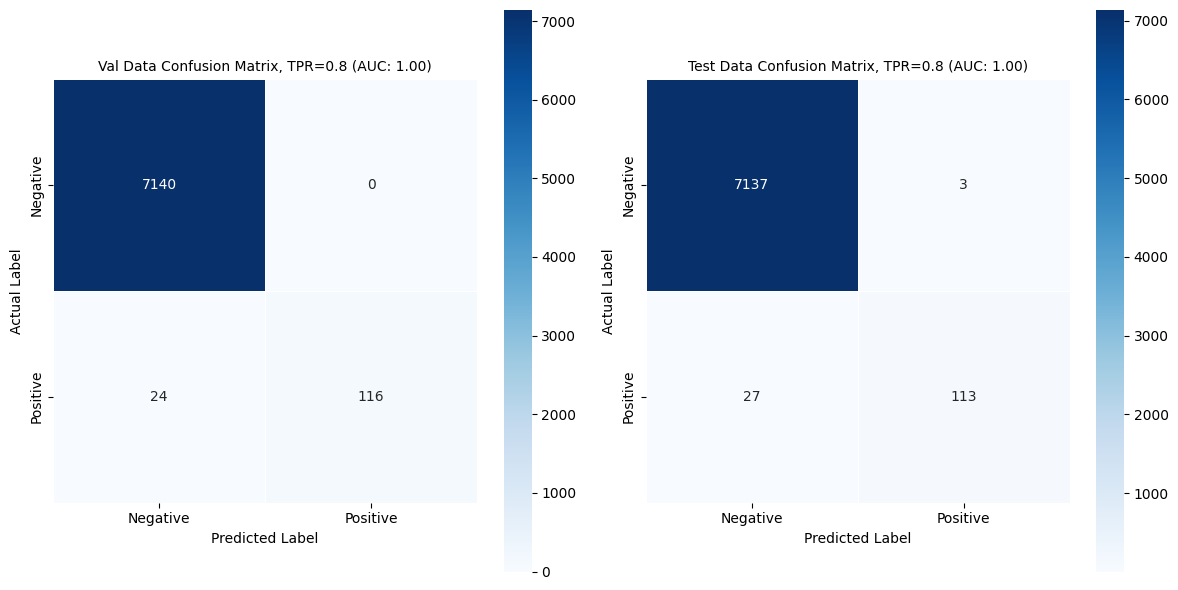

	- FPR Target: 0.05
		- Validation Accuracy: 0.9991758241758242
		- Validation Specificity: 0.9994397759103641
		- Test Accuracy: 0.9991758241758242
		- Test Specificity: 0.9995798319327731


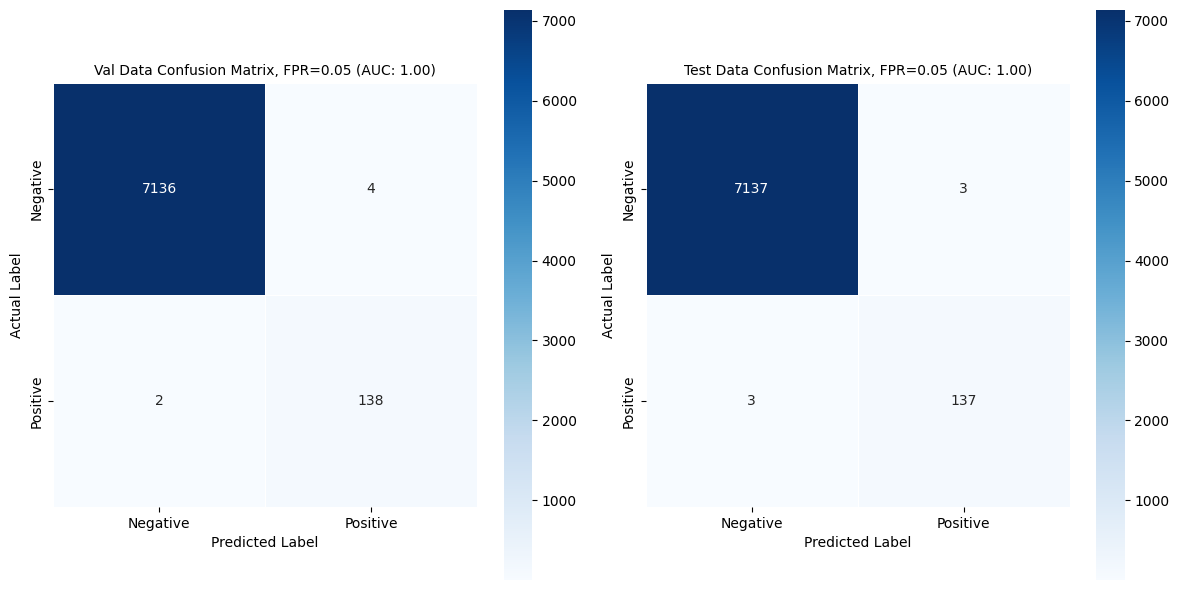

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 16
rnn_num_layers = 2
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #35

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [13:31<00:00,  8.12s/it]


	- Best Val AUC Epoch: 53
	- Best Val AUC: 0.999906962785114
	- Best Test AUC: 0.999859943977591


	- TPR Target: 0.8
		- Validation Accuracy: 0.9960164835164835
		- Validation Recall: 0.8
		- Test Accuracy: 0.9956043956043956
		- Test Recall: 0.7785714285714286


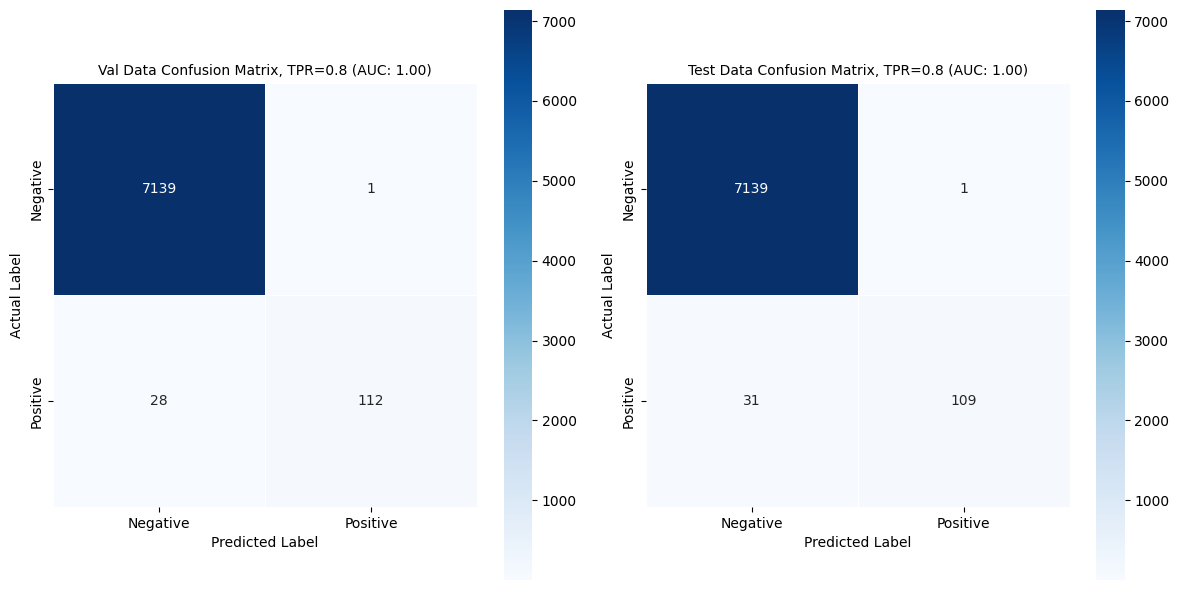

	- FPR Target: 0.05
		- Validation Accuracy: 0.9989010989010989
		- Validation Specificity: 0.9990196078431373
		- Test Accuracy: 0.9987637362637363
		- Test Specificity: 0.9995798319327731


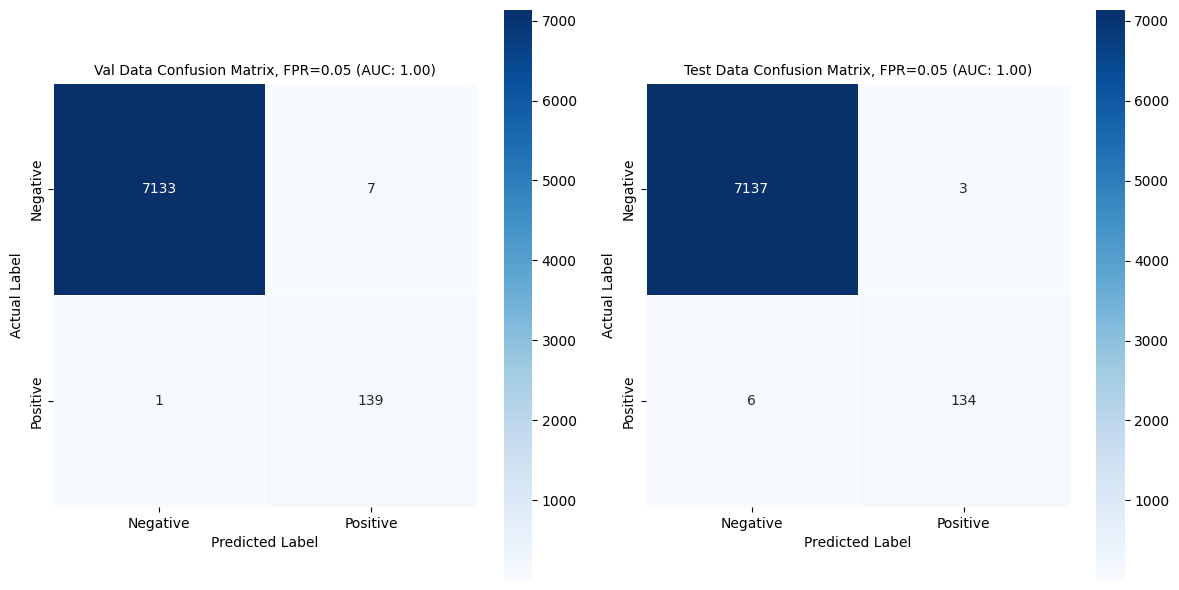

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 2
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #36

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:34<00:00, 11.14s/it]


	- Best Val AUC Epoch: 46
	- Best Val AUC: 0.9999629851940777
	- Best Test AUC: 0.9998949579831933


	- TPR Target: 0.8
		- Validation Accuracy: 0.9958791208791209
		- Validation Recall: 0.7857142857142857
		- Test Accuracy: 0.9883241758241759
		- Test Recall: 0.39285714285714285


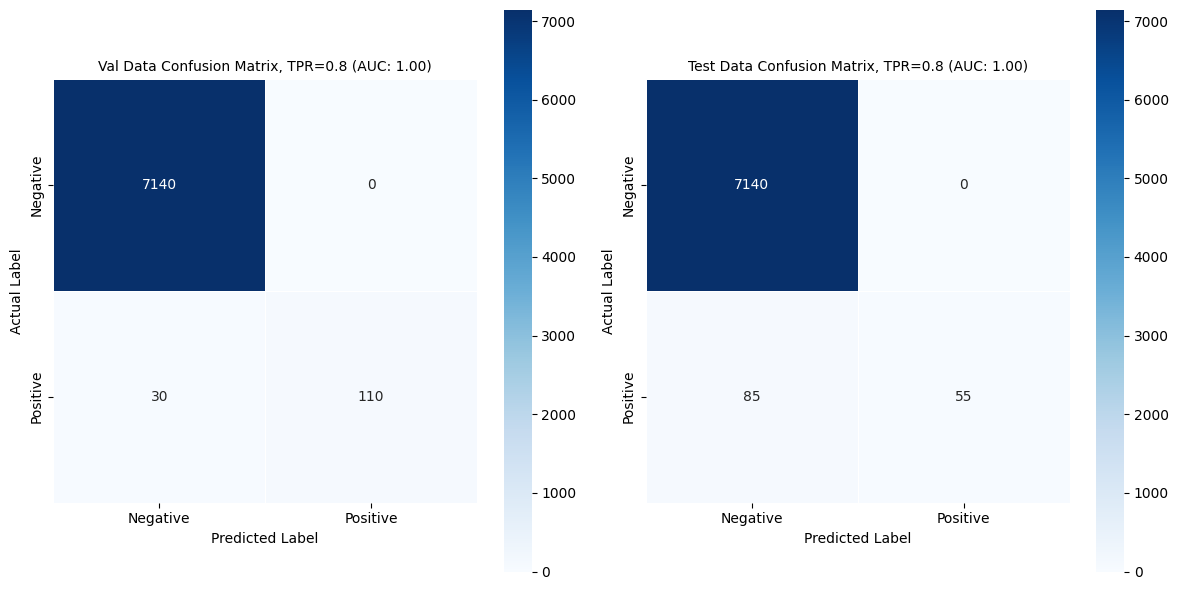

	- FPR Target: 0.05
		- Validation Accuracy: 0.9990384615384615
		- Validation Specificity: 0.9991596638655462
		- Test Accuracy: 0.9973901098901099
		- Test Specificity: 0.9997198879551821


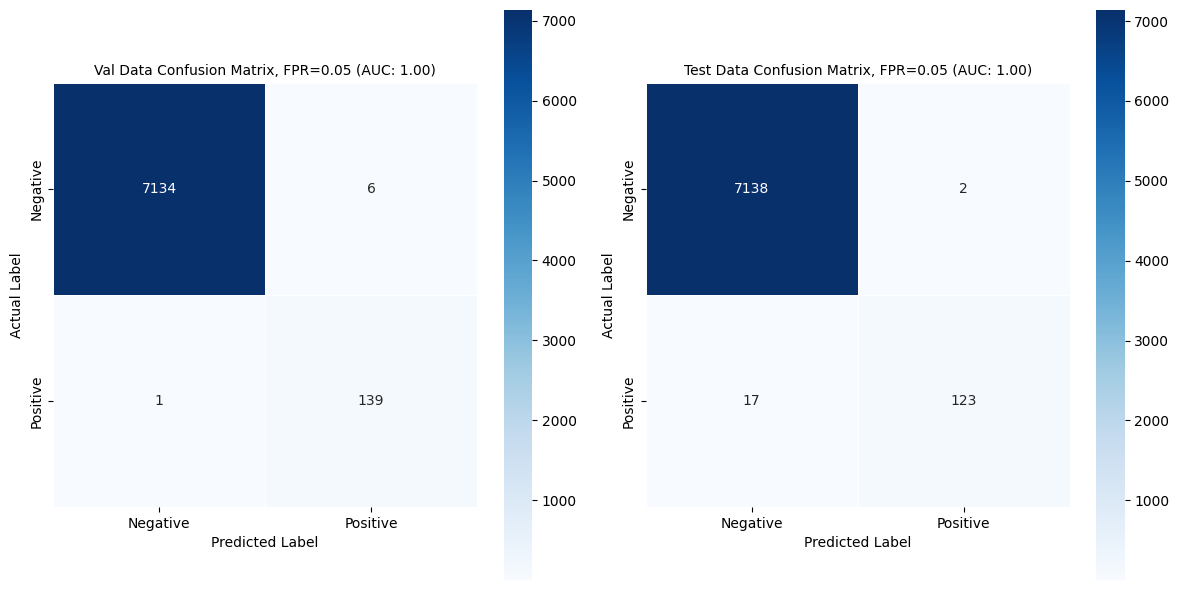

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.00
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #37 ***

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [20:08<00:00, 12.09s/it]


	- Best Val AUC Epoch: 29
	- Best Val AUC: 0.9999699879951981
	- Best Test AUC: 0.9998969587835134


	- TPR Target: 0.8
		- Validation Accuracy: 0.9973901098901099
		- Validation Recall: 0.8642857142857143
		- Test Accuracy: 0.9983516483516484
		- Test Recall: 0.9357142857142857


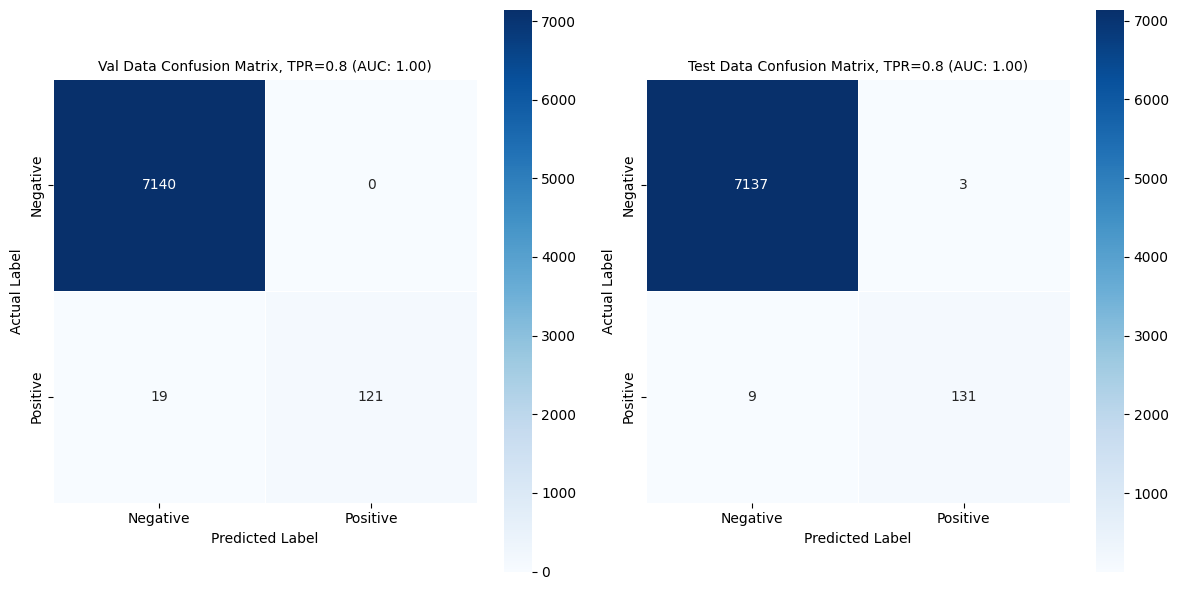

	- FPR Target: 0.05
		- Validation Accuracy: 0.9991758241758242
		- Validation Specificity: 0.9992997198879552
		- Test Accuracy: 0.9990384615384615
		- Test Specificity: 0.9992997198879552


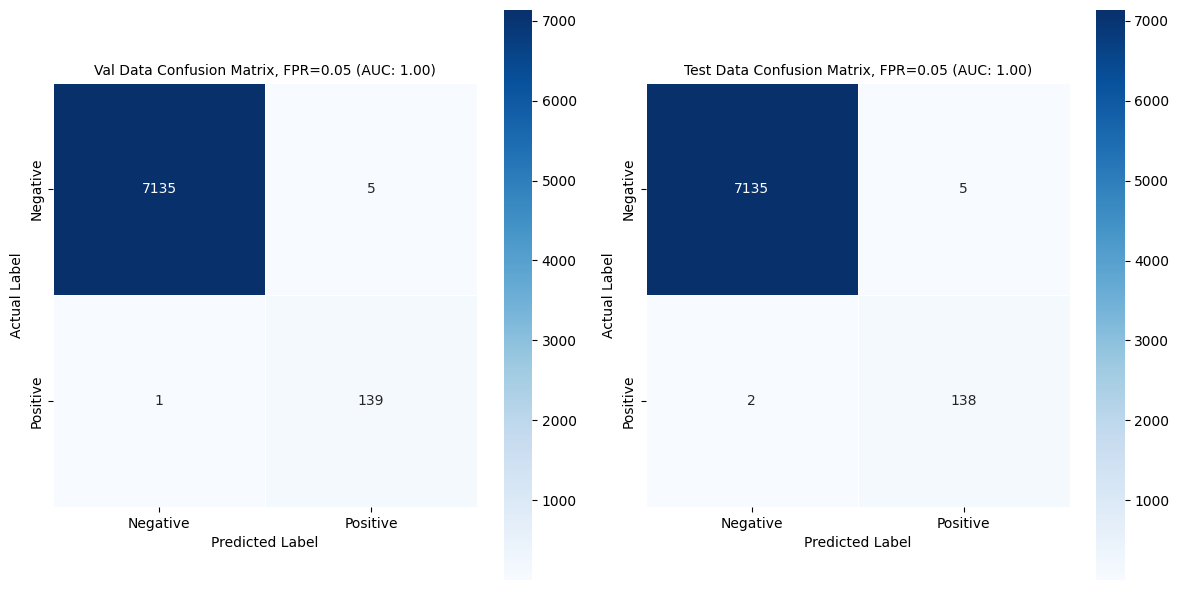

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #38

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [19:32<00:00, 11.72s/it]


	- Best Val AUC Epoch: 43
	- Best Val AUC: 0.9999559823929572
	- Best Test AUC: 0.9998829531812726


	- TPR Target: 0.8
		- Validation Accuracy: 0.9950549450549451
		- Validation Recall: 0.7428571428571429
		- Test Accuracy: 0.9991758241758242
		- Test Recall: 1.0


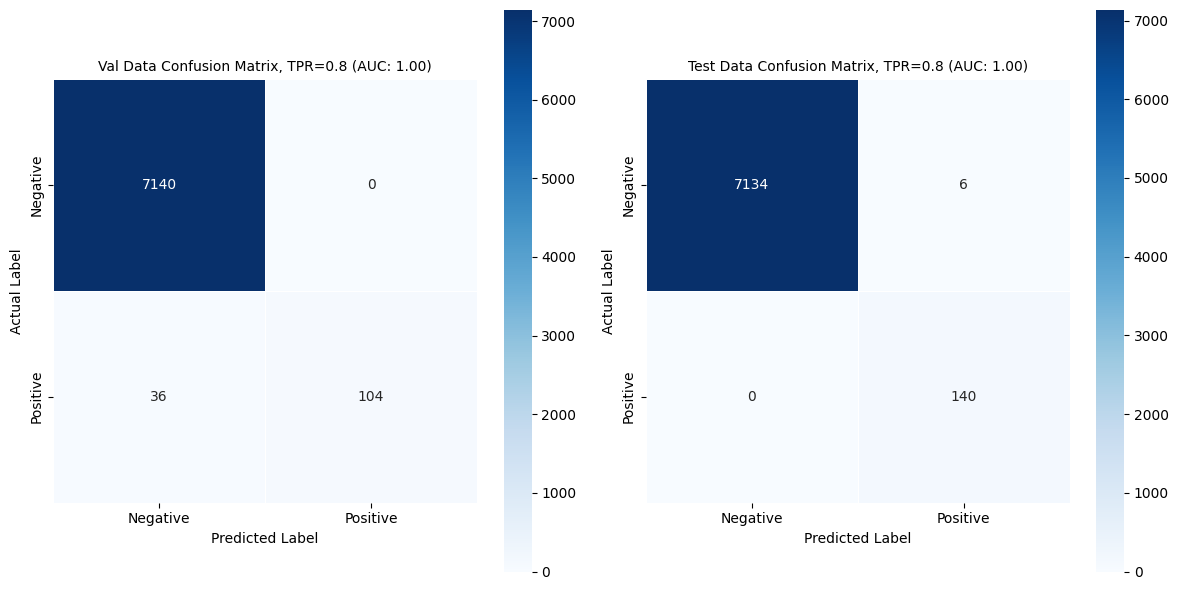

	- FPR Target: 0.05
		- Validation Accuracy: 0.9990384615384615
		- Validation Specificity: 0.9995798319327731
		- Test Accuracy: 0.998489010989011
		- Test Specificity: 0.9984593837535014


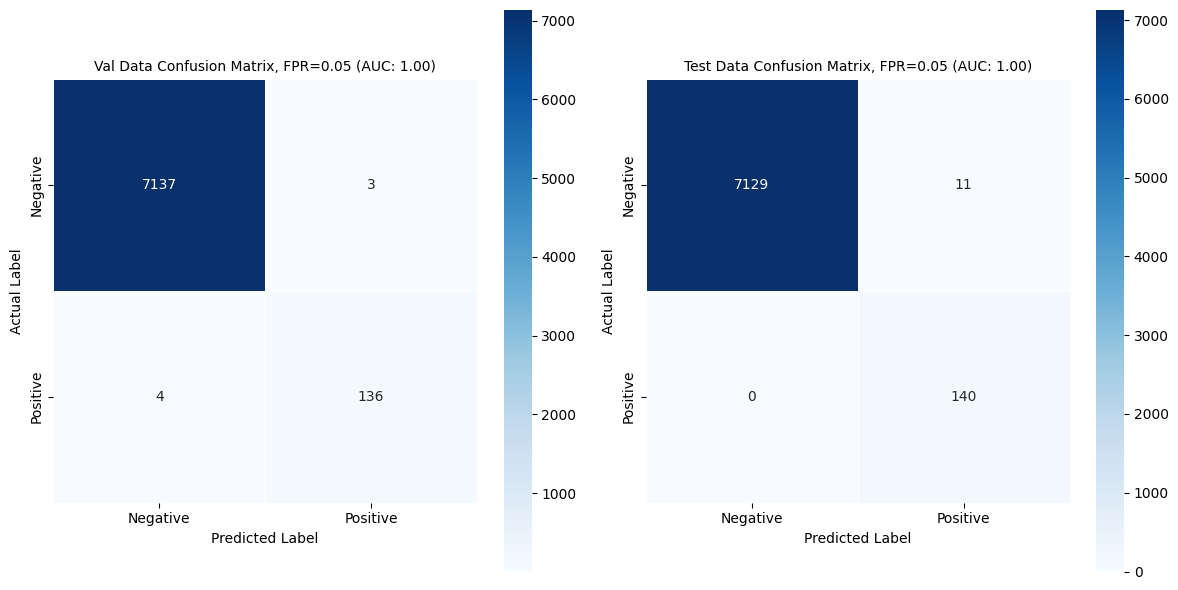

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #39

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:46<00:00, 11.27s/it]


	- Best Val AUC Epoch: 52
	- Best Val AUC: 0.999921968787515
	- Best Test AUC: 0.9998319327731092


	- TPR Target: 0.8
		- Validation Accuracy: 0.9982142857142857
		- Validation Recall: 0.9142857142857143
		- Test Accuracy: 0.996978021978022
		- Test Recall: 0.8571428571428571


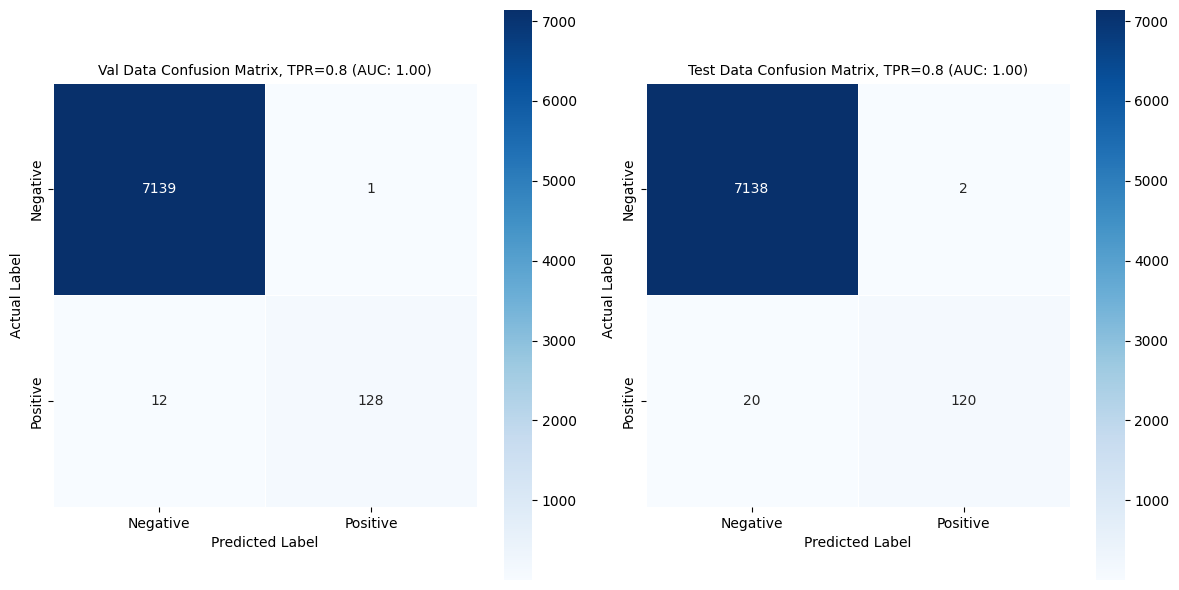

	- FPR Target: 0.05
		- Validation Accuracy: 0.9232142857142858
		- Validation Specificity: 0.9217086834733893
		- Test Accuracy: 0.9958791208791209
		- Test Specificity: 0.9957983193277311


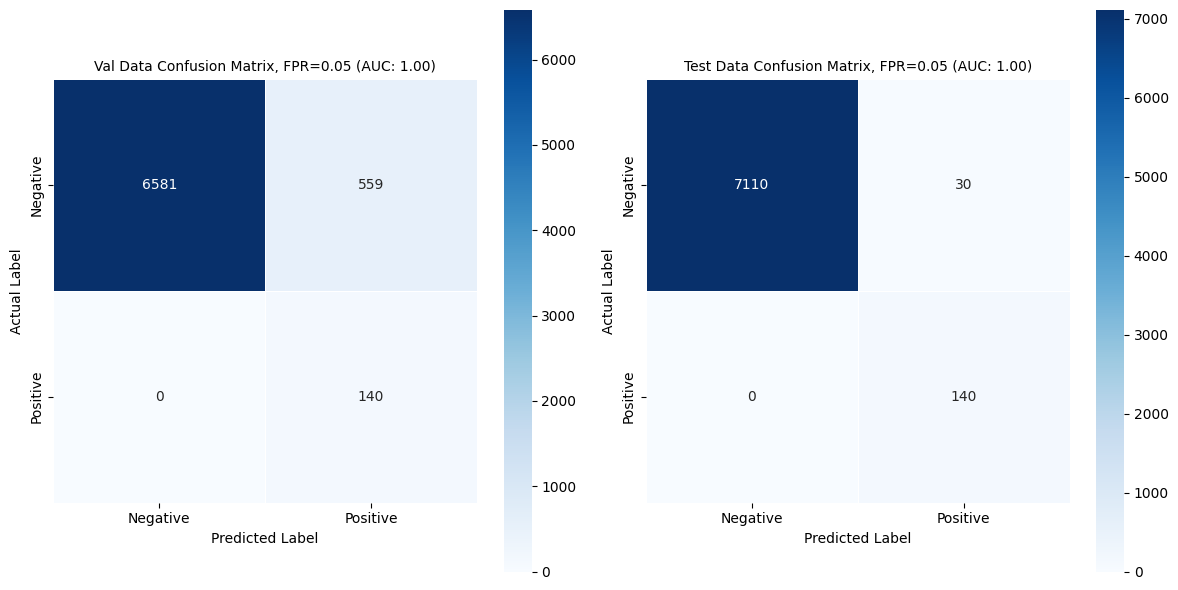

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.2
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #40

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [24:15<00:00, 14.55s/it]


	- Best Val AUC Epoch: 32
	- Best Val AUC: 0.9999629851940777
	- Best Test AUC: 0.9993827531012405


	- TPR Target: 0.8
		- Validation Accuracy: 0.9961538461538462
		- Validation Recall: 0.8
		- Test Accuracy: 0.9936813186813187
		- Test Recall: 0.7214285714285714


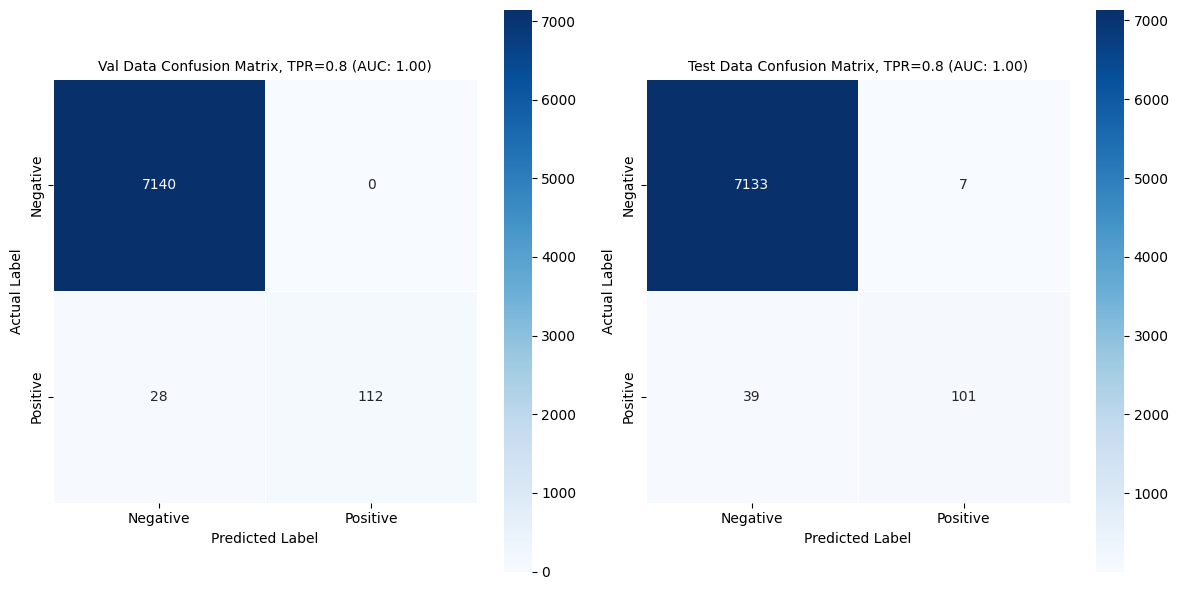

	- FPR Target: 0.05
		- Validation Accuracy: 0.9862637362637363
		- Validation Specificity: 0.9859943977591037
		- Test Accuracy: 0.019230769230769232
		- Test Specificity: 0.0


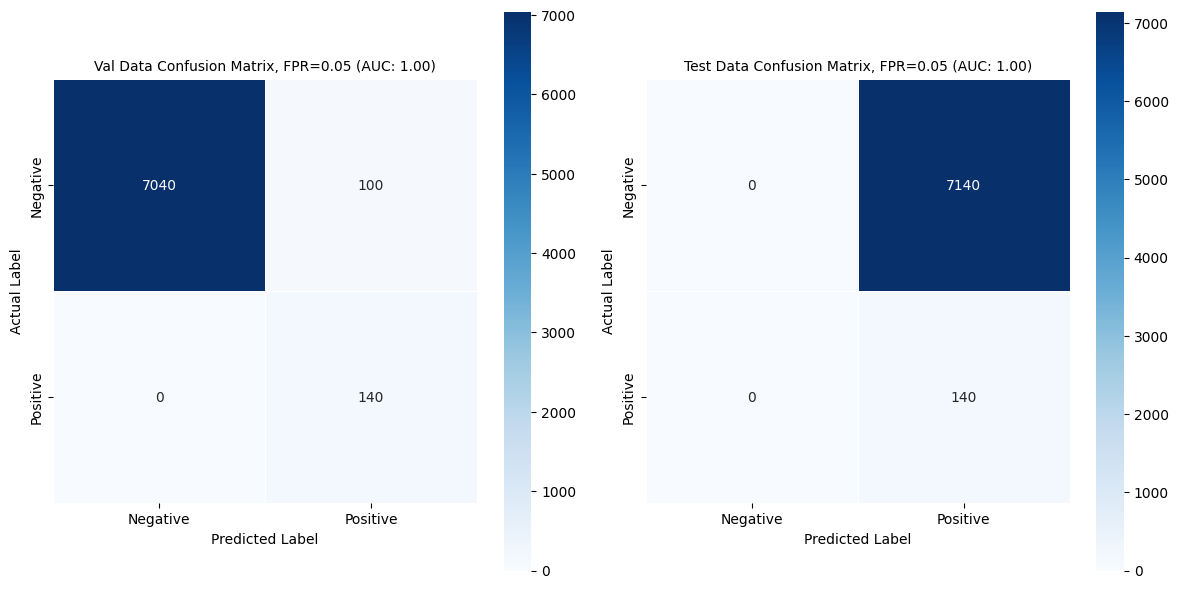

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [32]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #41

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [23:06<00:00, 13.86s/it]


	- Best Val AUC Epoch: 58
	- Best Val AUC: 0.9999439775910364
	- Best Test AUC: 0.9999359743897559


	- TPR Target: 0.8
		- Validation Accuracy: 0.9945054945054945
		- Validation Recall: 0.7142857142857143
		- Test Accuracy: 0.9851648351648352
		- Test Recall: 0.22857142857142856


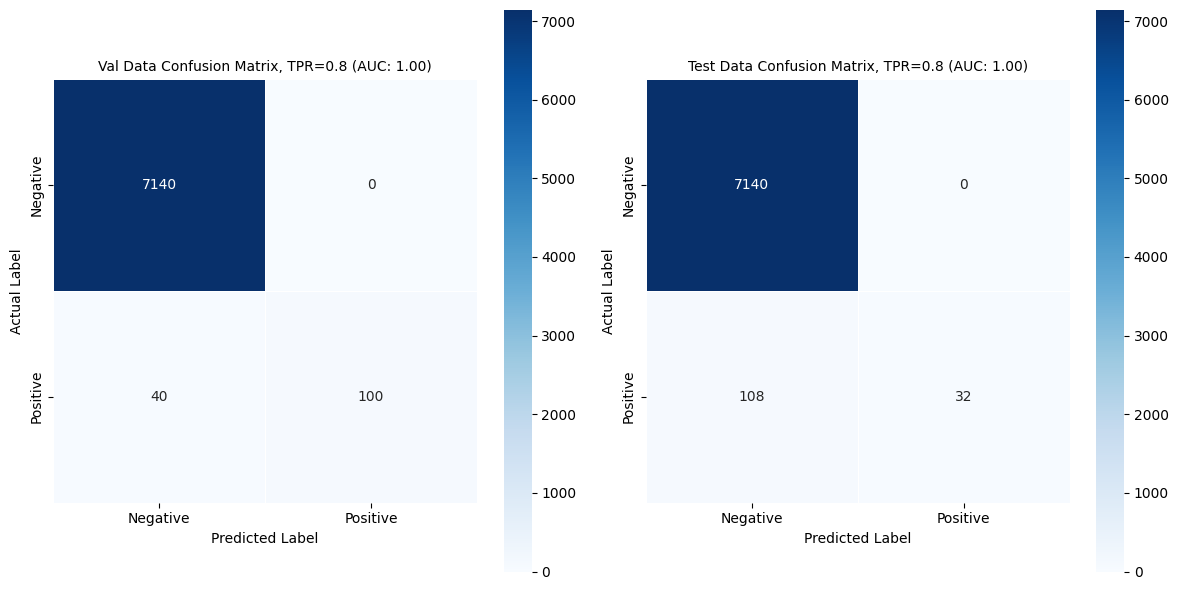

	- FPR Target: 0.05
		- Validation Accuracy: 0.9986263736263736
		- Validation Specificity: 0.9995798319327731
		- Test Accuracy: 0.9935439560439561
		- Test Specificity: 1.0


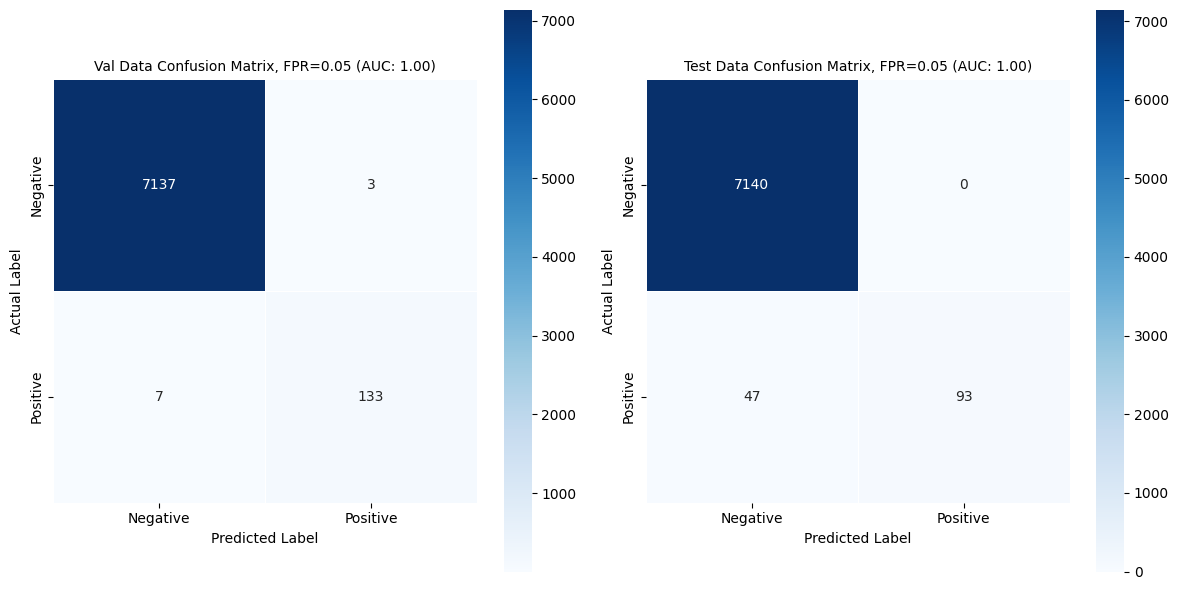

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16, 16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #42

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [22:42<00:00, 13.63s/it]


	- Best Val AUC Epoch: 75
	- Best Val AUC: 0.9999319727891157
	- Best Test AUC: 0.9998779511804721


	- TPR Target: 0.8
		- Validation Accuracy: 0.9973901098901099
		- Validation Recall: 0.8714285714285714
		- Test Accuracy: 0.9931318681318682
		- Test Recall: 0.65


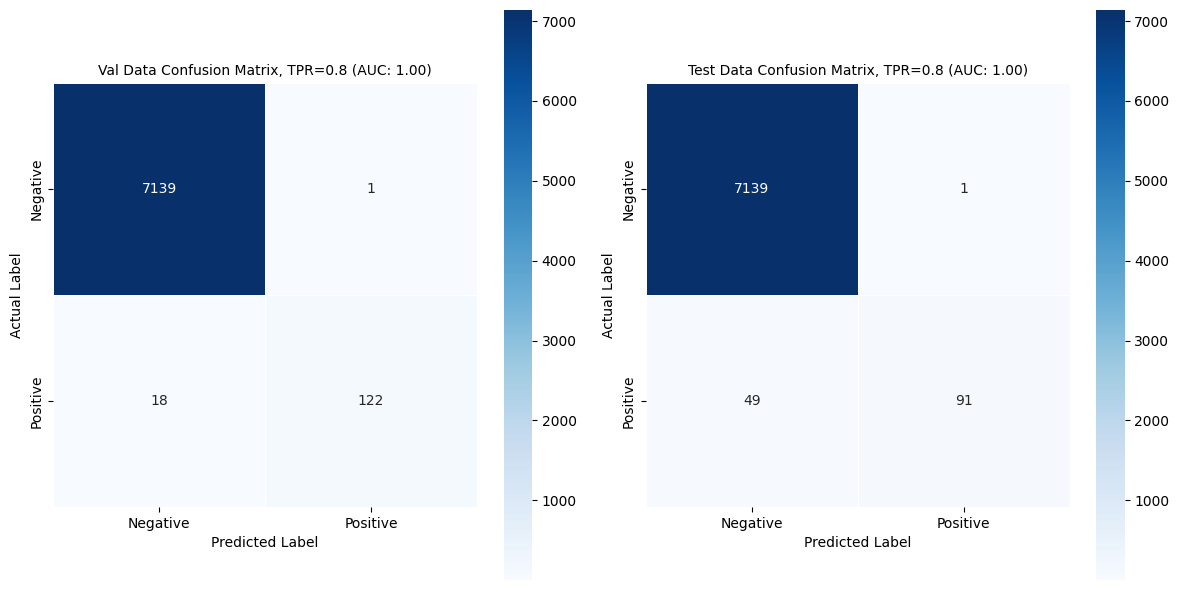

	- FPR Target: 0.05
		- Validation Accuracy: 0.9991758241758242
		- Validation Specificity: 0.9992997198879552
		- Test Accuracy: 0.998489010989011
		- Test Specificity: 0.9995798319327731


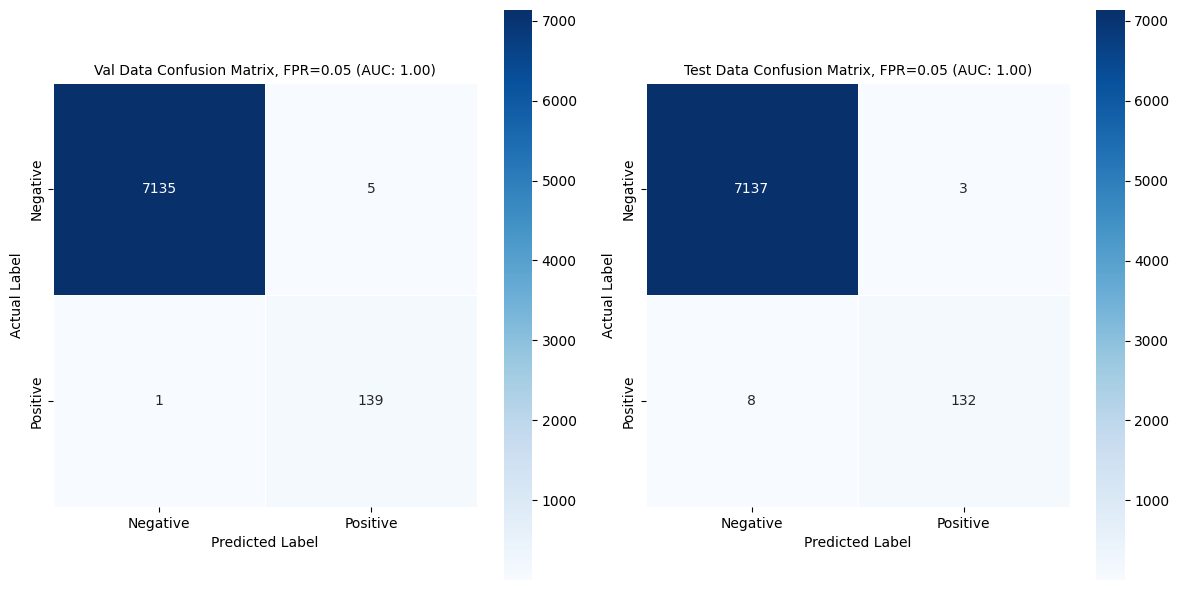

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [32, 32]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #43

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [14:45<00:00,  8.85s/it]


	- Best Val AUC Epoch: 99
	- Best Val AUC: 0.9441266506602641
	- Best Test AUC: 0.9125140056022409


	- TPR Target: 0.8
		- Validation Accuracy: 0.9195054945054945
		- Validation Recall: 0.8
		- Test Accuracy: 0.8875
		- Test Recall: 0.7642857142857142


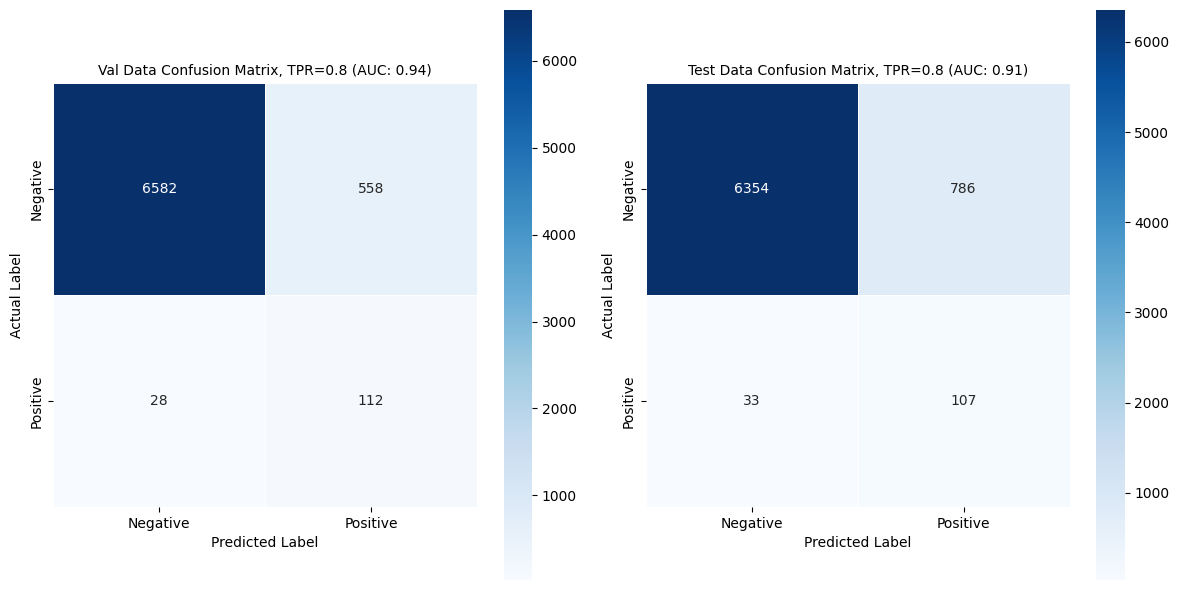

	- FPR Target: 0.05
		- Validation Accuracy: 0.9447802197802198
		- Validation Specificity: 0.95
		- Test Accuracy: 0.9454670329670329
		- Test Specificity: 0.95406162464986


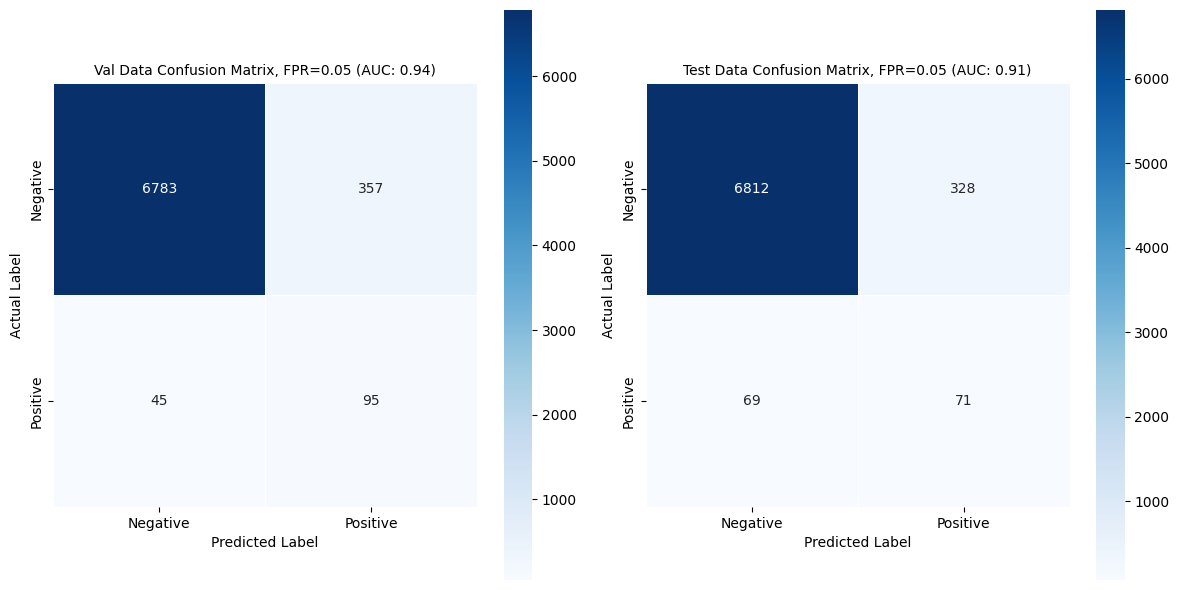

In [ ]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #44

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


	- Best Val AUC Epoch: 76
	- Best Val AUC: 0.9489340736294517
	- Best Test AUC: 0.8741666666666666


	- TPR Target: 0.8
		- Validation Accuracy: 0.9188186813186813
		- Validation Recall: 0.8
		- Test Accuracy: 0.9387362637362637
		- Test Recall: 0.45714285714285713


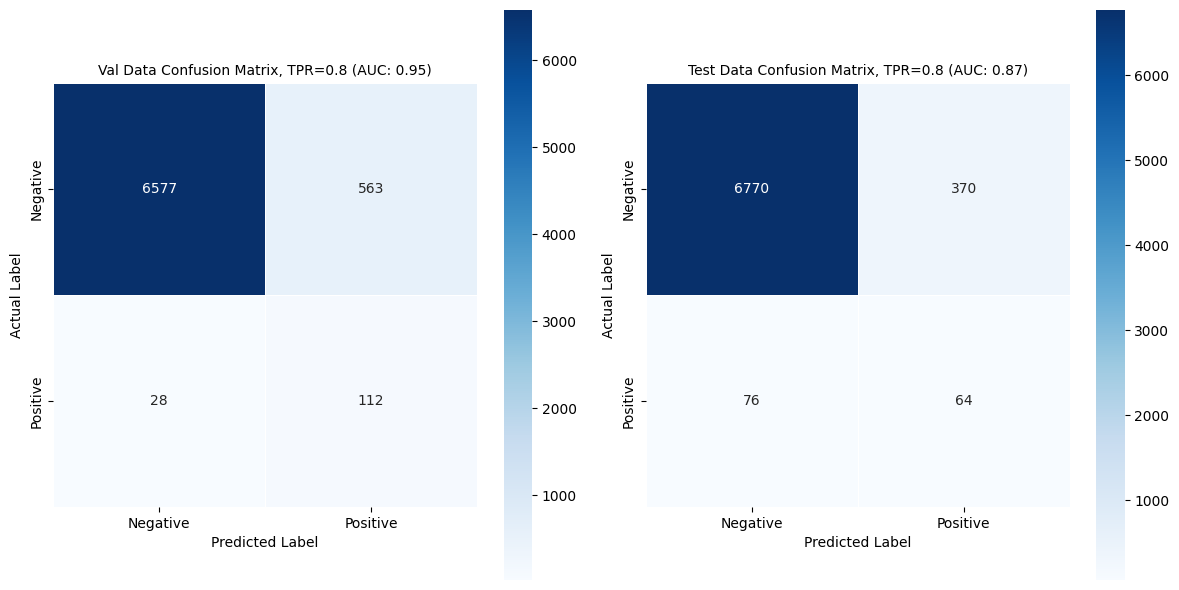

	- FPR Target: 0.05
		- Validation Accuracy: 0.9454670329670329
		- Validation Specificity: 0.9508403361344537
		- Test Accuracy: 0.9537087912087913
		- Test Specificity: 0.9649859943977591


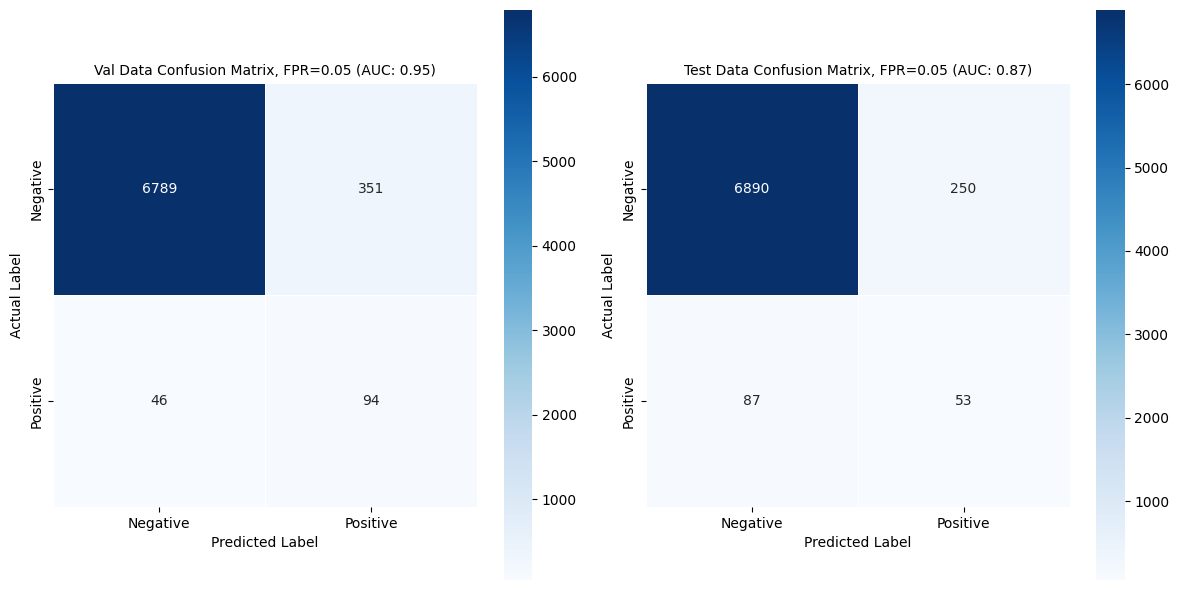

In [ ]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #45

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [20:22<00:00, 12.22s/it]


	- Best Val AUC Epoch: 95
	- Best Val AUC: 0.980799319727891
	- Best Test AUC: 0.9709633853541417


	- TPR Target: 0.8
		- Validation Accuracy: 0.9673076923076923
		- Validation Recall: 0.8
		- Test Accuracy: 0.9560439560439561
		- Test Recall: 0.7785714285714286


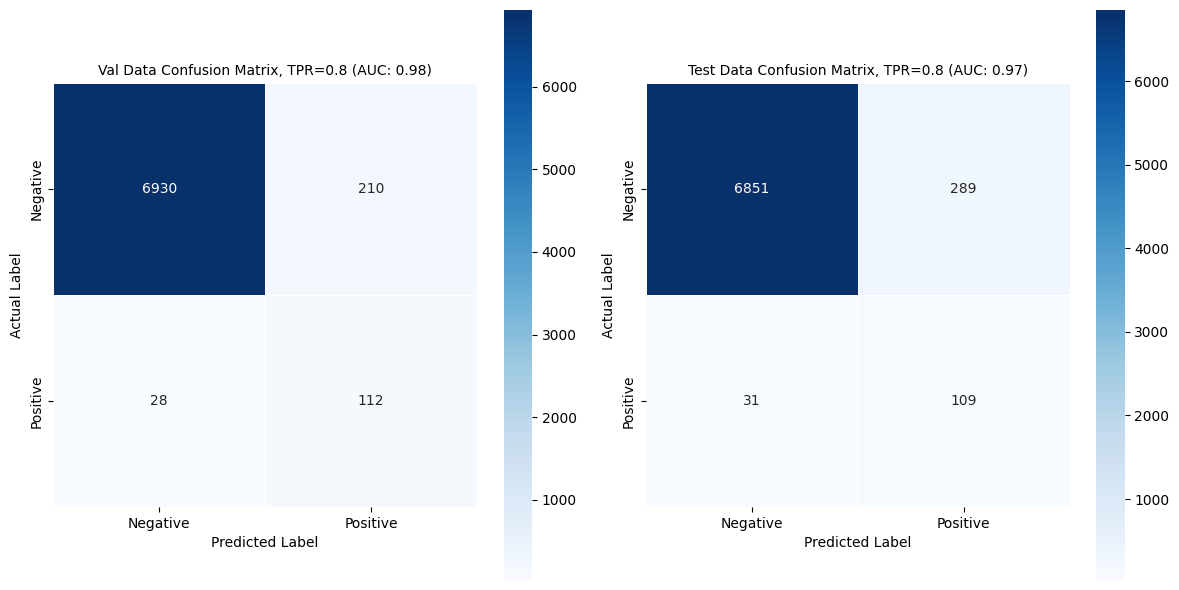

	- FPR Target: 0.05
		- Validation Accuracy: 0.9476648351648351
		- Validation Specificity: 0.9490196078431372
		- Test Accuracy: 0.9446428571428571
		- Test Specificity: 0.94593837535014


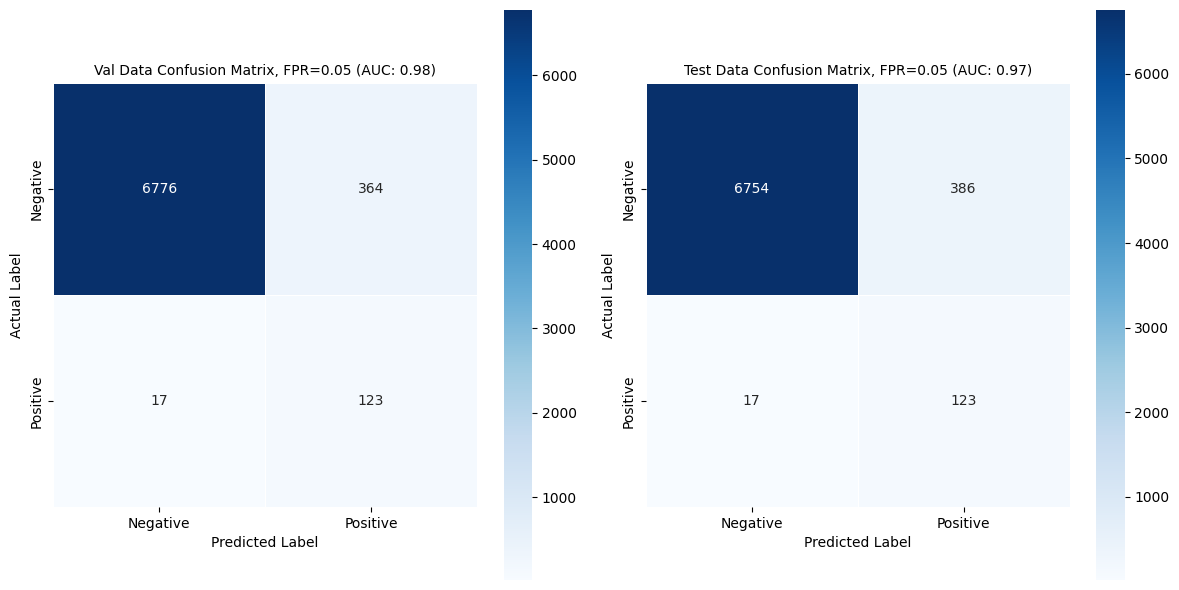

In [ ]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #46

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [14:51<00:00,  8.91s/it]


	- Best Val AUC Epoch: 96
	- Best Val AUC: 0.9874029611844738
	- Best Test AUC: 0.9678661464585835


	- TPR Target: 0.8
		- Validation Accuracy: 0.9809065934065934
		- Validation Recall: 0.8
		- Test Accuracy: 0.9763736263736263
		- Test Recall: 0.2714285714285714


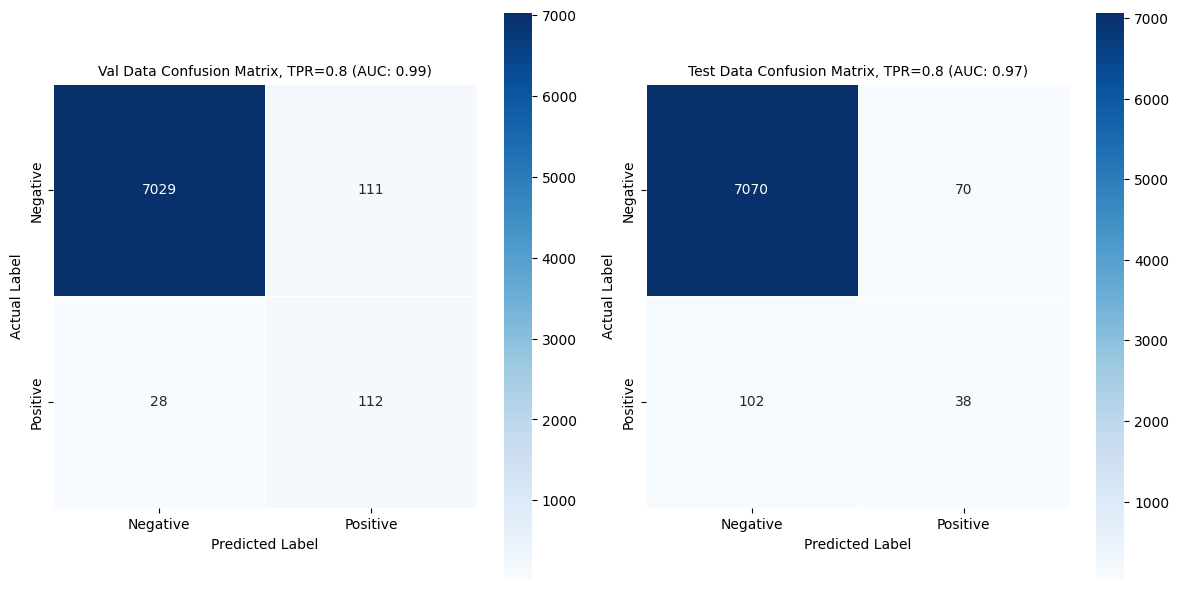

	- FPR Target: 0.05
		- Validation Accuracy: 0.9487637362637362
		- Validation Specificity: 0.9488795518207283
		- Test Accuracy: 0.9543956043956044
		- Test Specificity: 0.9589635854341737


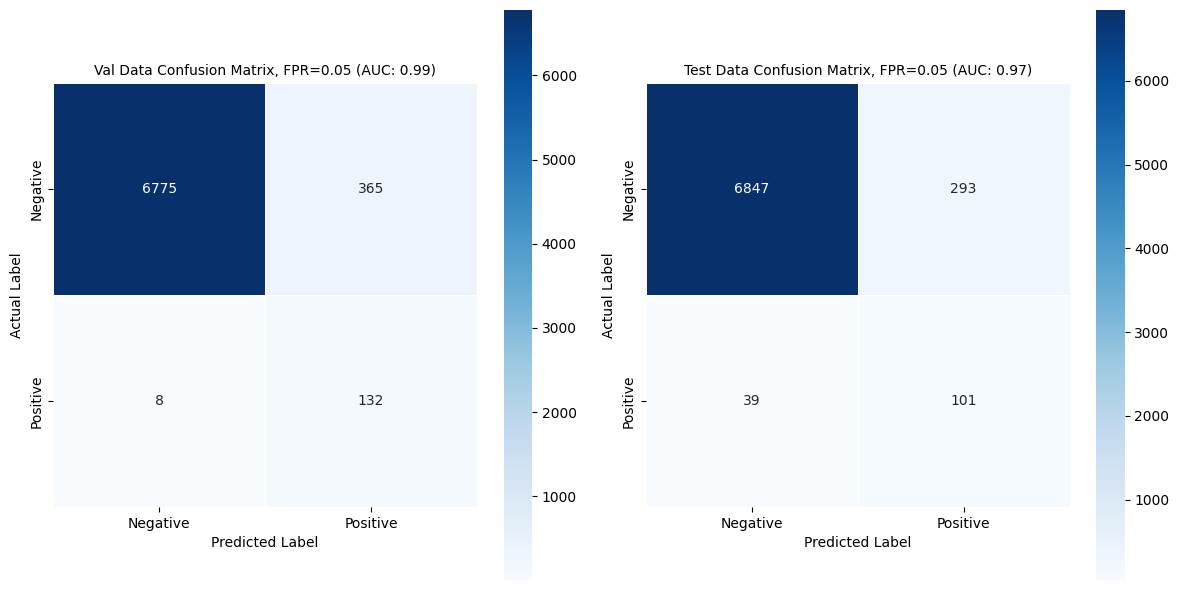

In [ ]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### Experiment #47

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [18:51<00:00, 11.31s/it]


	- Best Val AUC Epoch: 58
	- Best Val AUC: 0.9999349739895959
	- Best Test AUC: 0.9998789515806322


	- TPR Target: 0.8
		- Validation Accuracy: 0.9989010989010989
		- Validation Recall: 0.95
		- Test Accuracy: 0.9918956043956044
		- Test Recall: 0.5785714285714286


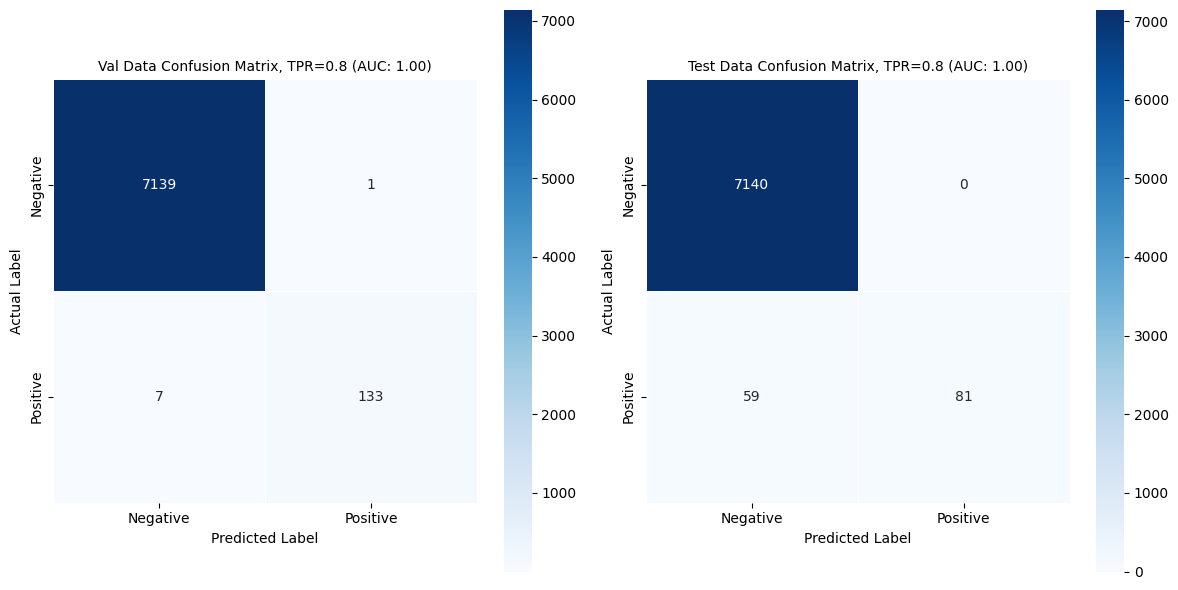

	- FPR Target: 0.05
		- Validation Accuracy: 0.9604395604395605
		- Validation Specificity: 0.9596638655462185
		- Test Accuracy: 0.9723901098901099
		- Test Specificity: 0.9718487394957983


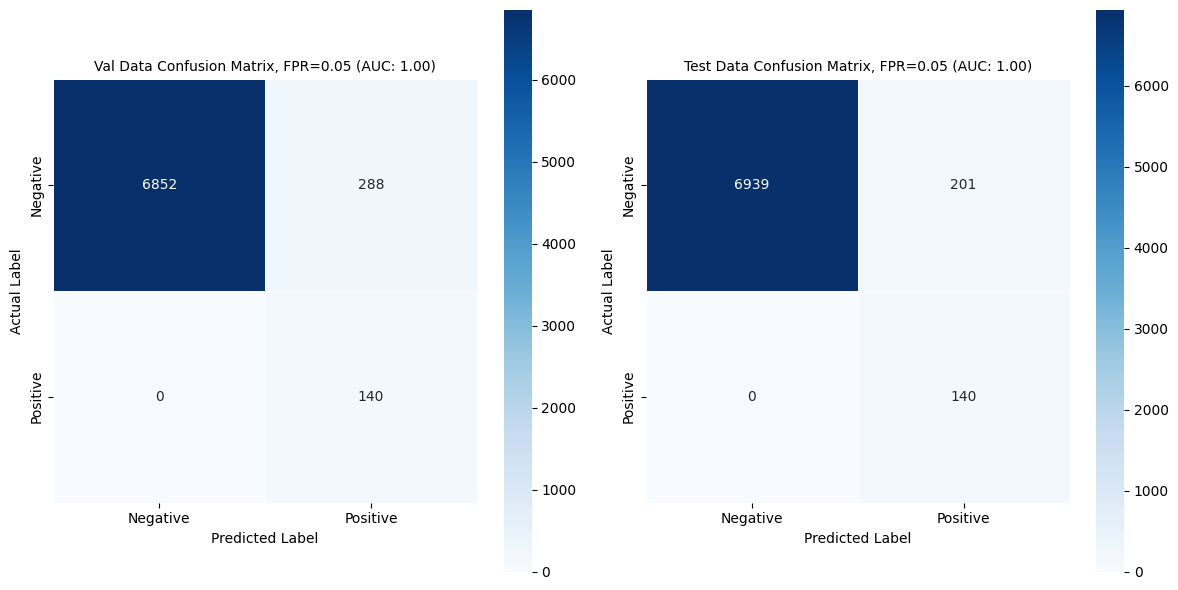

In [ ]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
best_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Best Test AUC: {best_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)